In [19]:
from __future__ import print_function
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt

import IPython.display as ipd
import seaborn as sns

import warnings
import os

import torch
from torch import nn, optim
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing

In [ ]:
audio_features = pd.read_csv('/root/autodl-tmp/SER/speech-emotion-recognition-iemocap-master/SER_new/preprocess_info/audio_features.csv')

In [5]:
audio_features.head()

,wav_file,label,flatness,zerocr,meancent,stdcent,maxcent,pitchmean,pitchmax,pitchmin,...,mel126,mel127,mel128,contrast1,contrast2,contrast3,contrast4,contrast5,contrast6,contrast7
0,Ses01F_impro07_F000,2,0.000117,0.104217,0.003497,0.000913,0.007629,39.980061,177.585068,0.0,...,3.798325e-09,3.733791e-09,3.692167e-09,16.536948,16.284672,18.475872,17.406281,18.586443,19.425038,60.520979
1,Ses01F_impro07_F001,8,0.000100,0.075618,0.004464,0.001144,0.007696,21.843964,261.220825,0.0,...,7.410554e-09,7.287094e-09,7.207958e-09,17.575806,17.309719,20.956048,19.172998,18.847347,21.096493,57.565071
2,Ses01F_impro07_F002,2,0.000101,0.077476,0.001927,0.000580,0.005425,52.412819,177.578827,0.0,...,1.549797e-10,1.554628e-10,1.556276e-10,19.414308,15.665443,18.314568,16.283157,18.249842,20.907595,56.390271
3,Ses01F_impro07_F003,2,0.000127,0.096310,0.009709,0.002803,0.019800,94.230263,392.959503,0.0,...,1.685343e-09,1.672188e-09,1.663302e-09,15.788588,16.966773,20.352470,17.047441,18.516419,18.303163,59.933493
4,Ses01F_impro07_F004,2,0.000095,0.071841,0.004348,0.002400,0.015057,38.384247,123.568802,0.0,...,2.821108e-09,2.770337e-09,2.737887e-09,19.126089,17.503988,19.685403,17.224310,17.393296,17.973519,58.017080


In [6]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8,
                'dis': 8}

In [7]:
audio_features.label.value_counts()

8    2634
4    1870
7    1791
0    1146
2    1140
3    1107
1     691
6     115
5      47
Name: label, dtype: int64

In [8]:
audio_4emotions = audio_features[audio_features["label"].isin([0, 1, 3, 7])]

In [9]:
audio_4emotions.shape

(4735, 201)

In [10]:
def emotion(x):
    if x == 0:
        return "angry"
    elif x == 1:
        return "happy"
    elif x == 3:
        return "sadness"
    else:
        return 'neutral'

In [11]:
audio_4emotions["emotion"] = audio_4emotions["label"].apply(emotion)

In [12]:
def label_new(x):
    if x == 0:
        return 0
    elif x == 1:
        return 1
    elif x == 3:
        return 2
    else:
        return 3

In [13]:
audio_4emotions["label"] = audio_4emotions["label"].apply(label_new)

In [14]:
audio_4emotions["label"].value_counts()

3    1791
0    1146
2    1107
1     691
Name: label, dtype: int64

In [15]:
audio_4emotions.head()

,wav_file,label,flatness,zerocr,meancent,stdcent,maxcent,pitchmean,pitchmax,pitchmin,...,mel127,mel128,contrast1,contrast2,contrast3,contrast4,contrast5,contrast6,contrast7,emotion
29,Ses01F_impro07_M012,3,0.000264,0.086800,0.005208,0.002313,0.012480,52.247543,177.034454,0.0,...,5.105860e-10,5.038546e-10,19.750377,15.499886,18.575094,15.056193,17.538725,19.044305,59.164065,neutral
30,Ses01F_impro07_M013,3,0.000137,0.085653,0.007576,0.002925,0.017714,45.628986,304.920471,0.0,...,3.031110e-09,2.988381e-09,17.702971,16.291229,19.608798,16.181942,18.710160,19.209586,59.037311,neutral
35,Ses01F_impro07_M018,3,0.000157,0.074389,0.004854,0.001993,0.011810,21.954649,166.751450,0.0,...,6.656347e-09,6.560833e-09,19.837422,14.379512,19.636331,15.115151,17.851278,19.918788,57.848201,neutral
36,Ses01F_impro07_M019,1,0.000156,0.071291,0.001764,0.000529,0.003536,45.127403,209.938751,0.0,...,6.268069e-10,6.140121e-10,18.339358,14.827830,17.913266,15.262304,17.552523,18.375426,55.534309,happy
37,Ses01F_impro03_F000,1,0.000240,0.070553,0.008065,0.001883,0.014427,4.144345,131.188599,0.0,...,5.197816e-09,5.132288e-09,18.666856,16.702341,17.092052,15.970437,17.295833,20.087279,56.297245,happy


In [16]:
audio_4emotions.columns.get_loc("emotion")

201

In [21]:
train_raw = audio_4emotions.iloc[:, 2:201]

In [22]:
min_max_scaler = preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(train_raw)
train_scaled = pd.DataFrame(scaled)
train_scaled.columns = train.columns
train_scaled.head()

,flatness,zerocr,meancent,stdcent,maxcent,pitchmean,pitchmax,pitchmin,pitchstd,pitch_tuning_offset,...,mel126,mel127,mel128,contrast1,contrast2,contrast3,contrast4,contrast5,contrast6,contrast7
0,0.122290,0.342139,0.146811,0.134667,0.158635,0.302040,0.438479,0.0,0.419174,0.000000,...,0.000007,0.000007,0.000007,0.734755,0.409187,0.535310,0.208050,0.413324,0.295239,0.697496
1,0.054771,0.335586,0.224373,0.174491,0.239353,0.263778,0.755227,0.0,0.569879,0.090909,...,0.000042,0.000042,0.000042,0.553417,0.473403,0.626919,0.314676,0.591676,0.309186,0.691449
2,0.065692,0.271237,0.135214,0.113795,0.148294,0.126919,0.413010,0.0,0.292184,0.717172,...,0.000093,0.000093,0.000093,0.742465,0.318271,0.629359,0.213634,0.460911,0.369030,0.634724
3,0.064940,0.253534,0.033955,0.018562,0.020694,0.260879,0.519976,0.0,0.447900,0.131313,...,0.000009,0.000009,0.000009,0.609781,0.354651,0.476657,0.227572,0.415425,0.238797,0.524342
4,0.109642,0.249318,0.240386,0.106676,0.188649,0.023958,0.324928,0.0,0.119808,1.000000,...,0.000073,0.000073,0.000073,0.638788,0.506764,0.403880,0.294643,0.376344,0.383248,0.560737


In [23]:
train = train_scaled.values.astype(np.float32)
target = audio_4emotions.iloc[:, 1].values

In [24]:
torch.cuda.is_available()

True

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(train, target, stratify=target, test_size=0.2)

In [27]:
len(X_train)

3788

In [28]:
Counter(y_train)

Counter({0: 917, 1: 553, 2: 885, 3: 1433})

In [29]:
Counter(y_test)

Counter({0: 229, 1: 138, 2: 222, 3: 358})

In [30]:
batch_size = 128

In [31]:
class AudioDataset_train(Dataset):
    """
    Diabetes Dataset
    """
    
    def __init__(self):
        self.len = len(X_train)
        self.x_data = torch.from_numpy(X_train)
        self.y_data = torch.from_numpy(y_train)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    
traindataset = AudioDataset_train()

trainloader = DataLoader(dataset=traindataset,
                          batch_size=batch_size,
                          shuffle=True)

In [32]:
class AudioDataset_test(Dataset):
    """
    Diabetes Dataset
    """
    
    def __init__(self):
        self.len = len(X_test)
        self.x_data = torch.from_numpy(X_test)
        self.y_data = torch.from_numpy(y_test)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    
testdataset = AudioDataset_test()

testloader = DataLoader(dataset=testdataset,
                          batch_size=batch_size)

In [26]:
len(testloader)

8

In [26]:
testiter = iter(testloader)
features, labels = next(testiter)
features.shape, labels.shape

(torch.Size([128, 199]), torch.Size([128]))

In [27]:
features.type()

'torch.FloatTensor'

In [87]:
class Net(nn.Module):
    
    
    def __init__(self):
        
        super(Net, self).__init__()
        self.l1 = nn.Linear(199, 300)
#         self.l2 = nn.Linear(200, 100)
#         self.l3 = nn.Linear(100, 50)
#         self.l4 = nn.Linear(50, 4)
        
        self.l5 = nn.Linear(300, 4)
        
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x): # flattening (n, 1, 28, 28)--> (n, 784)
        x = F.relu(self.l1(x))
#         x = F.relu(self.l2(x))
#         x = self.dropout(x)
#         x = F.relu(self.l3(x))
        x = self.dropout(x)
        return F.softmax(self.l5(x))
        
        
# intantiation

net = Net()

In [ ]:
def plot_confusion_matrix(actual, predicted, labels):
    cm = confusion_matrix(actual, predicted, labels=labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, annot_kws={"size": 10}, fmt='.0f'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    plt.show()

In [35]:
anger = 0
happiness = 0
neutral = 0
sadness = 0

for _, target in trainloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])
    
for _, target in testloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])

In [36]:
print("anger {} happiness {} neutral {} sadness {}".format(anger, happiness, neutral, sadness))

anger 1146 happiness 691 neutral 1107 sadness 1791


In [37]:
sample_weights = [1/anger, 1/happiness, 1/neutral, 1/sadness]
class_weights = torch.FloatTensor(sample_weights).cuda()
class_weights

tensor([0.0009, 0.0014, 0.0009, 0.0006], device='cuda:0')

In [38]:
label_to_class = {0: 'anger', 1: 'happiness', 2: 'neutral', 3: 'sadness'}

In [39]:
final_labels = ['anger', 'happiness', 'neutral', 'sadness']

In [89]:
# instantiation
model = Net()

In [90]:
model.to(device)

Net(
  (l1): Linear(in_features=199, out_features=300, bias=True)
  (l5): Linear(in_features=300, out_features=4, bias=True)
  (dropout): Dropout(p=0.4)
)

In [91]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [92]:
# optimizer and criterion
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.003)

optimizer = optim.Adam(model.parameters(), lr=0.003)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [93]:
def train(epoch, model):
    model.train()
    correct_train = 0
    train_loss = 0
    train_acc = 0
    
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        # zero the gradient, forward, backward and running pytorch rhythm
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct_train += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    
    train_loss /= len(trainloader.dataset)
    train_acc = 100. * correct_train / len(trainloader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(train_loss))
    print('\nTrain Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct_train, len(trainloader.dataset), 100. * correct_train / len(trainloader.dataset)))
    
    return train_loss, int(train_acc.numpy())
            

In [94]:
def test(model):
    model.eval()
    test_loss = 0
    test_acc = 0
    correct = 0
    history_test = []

    pred_model = []
    actual = []

    for data, target in testloader:
        data, target = data.to(device), target.to(device)

        # output from model
        output = model(data)

        # sum total loss
        test_loss += criterion(output, target).item()

        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        pred_model.append(pred.cpu().numpy())
        actual.append(target.data.cpu().numpy())


    test_loss /= len(testloader.dataset)
    test_acc = 100. * correct / len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


    pred_with_label = [label_to_class[label] for label in list(np.concatenate(pred_model))]
    actual_with_label = [label_to_class[label] for label in list(np.concatenate(actual))]

    plot_confusion_matrix(actual_with_label, pred_with_label, final_labels)

    print('\n Classification Report \n {} \n'.format(classification_report(actual_with_label, pred_with_label)))

    return test_loss, int(test_acc.numpy())

Train Epoch: 1 [0/3788 (0%)]	Loss: 1.386761

Train Epoch: 1 [1280/3788 (33%)]	Loss: 1.333550

Train Epoch: 1 [2560/3788 (67%)]	Loss: 1.292053


Train set: Average loss: 0.0103


Train Accuracy: 1556/3788 (41%)


Test set: Average loss: 0.0106, Accuracy: 399/947 (42%)



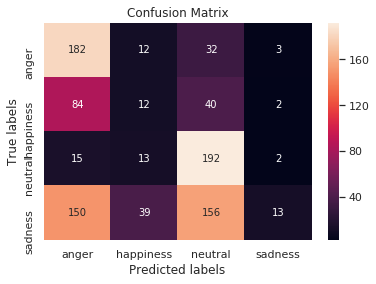


 Classification Report 
              precision    recall  f1-score   support

      anger       0.42      0.79      0.55       229
  happiness       0.16      0.09      0.11       138
    neutral       0.46      0.86      0.60       222
    sadness       0.65      0.04      0.07       358

avg / total       0.48      0.42      0.32       947
 

Train Epoch: 2 [0/3788 (0%)]	Loss: 1.248267

Train Epoch: 2 [1280/3788 (33%)]	Loss: 1.241403

Train Epoch: 2 [2560/3788 (67%)]	Loss: 1.214009


Train set: Average loss: 0.0098


Train Accuracy: 1833/3788 (48%)


Test set: Average loss: 0.0103, Accuracy: 510/947 (53%)



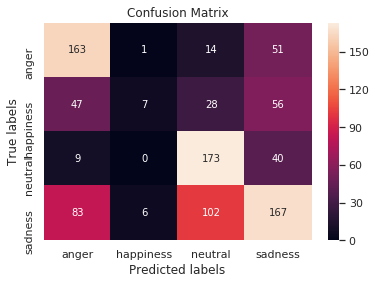


 Classification Report 
              precision    recall  f1-score   support

      anger       0.54      0.71      0.61       229
  happiness       0.50      0.05      0.09       138
    neutral       0.55      0.78      0.64       222
    sadness       0.53      0.47      0.50       358

avg / total       0.53      0.54      0.50       947
 

Train Epoch: 3 [0/3788 (0%)]	Loss: 1.253370

Train Epoch: 3 [1280/3788 (33%)]	Loss: 1.224907

Train Epoch: 3 [2560/3788 (67%)]	Loss: 1.210084


Train set: Average loss: 0.0096


Train Accuracy: 1936/3788 (51%)


Test set: Average loss: 0.0101, Accuracy: 489/947 (51%)



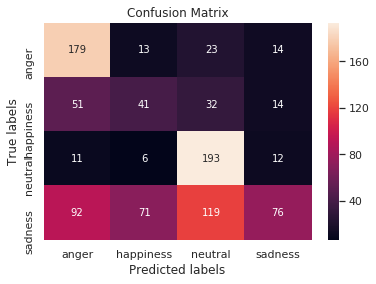


 Classification Report 
              precision    recall  f1-score   support

      anger       0.54      0.78      0.64       229
  happiness       0.31      0.30      0.30       138
    neutral       0.53      0.87      0.66       222
    sadness       0.66      0.21      0.32       358

avg / total       0.55      0.52      0.47       947
 

Train Epoch: 4 [0/3788 (0%)]	Loss: 1.182196

Train Epoch: 4 [1280/3788 (33%)]	Loss: 1.175153

Train Epoch: 4 [2560/3788 (67%)]	Loss: 1.198307


Train set: Average loss: 0.0095


Train Accuracy: 1994/3788 (52%)


Test set: Average loss: 0.0099, Accuracy: 544/947 (57%)



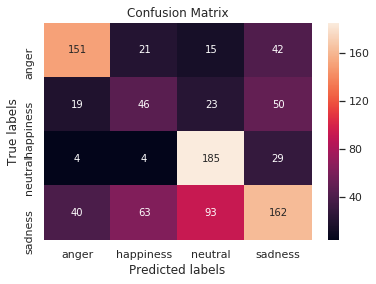


 Classification Report 
              precision    recall  f1-score   support

      anger       0.71      0.66      0.68       229
  happiness       0.34      0.33      0.34       138
    neutral       0.59      0.83      0.69       222
    sadness       0.57      0.45      0.51       358

avg / total       0.57      0.57      0.57       947
 

Train Epoch: 5 [0/3788 (0%)]	Loss: 1.164785

Train Epoch: 5 [1280/3788 (33%)]	Loss: 1.142582

Train Epoch: 5 [2560/3788 (67%)]	Loss: 1.172845


Train set: Average loss: 0.0094


Train Accuracy: 2058/3788 (54%)


Test set: Average loss: 0.0098, Accuracy: 515/947 (54%)



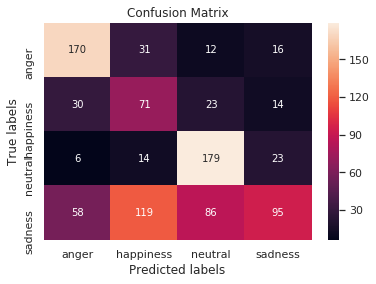


 Classification Report 
              precision    recall  f1-score   support

      anger       0.64      0.74      0.69       229
  happiness       0.30      0.51      0.38       138
    neutral       0.60      0.81      0.69       222
    sadness       0.64      0.27      0.38       358

avg / total       0.58      0.54      0.52       947
 

Train Epoch: 6 [0/3788 (0%)]	Loss: 1.196897

Train Epoch: 6 [1280/3788 (33%)]	Loss: 1.120720

Train Epoch: 6 [2560/3788 (67%)]	Loss: 1.180138


Train set: Average loss: 0.0093


Train Accuracy: 2065/3788 (54%)


Test set: Average loss: 0.0098, Accuracy: 517/947 (54%)



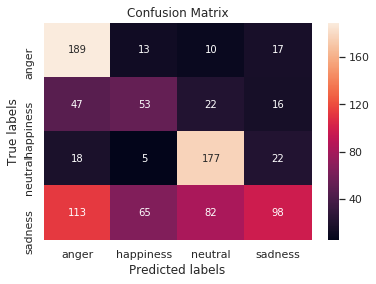


 Classification Report 
              precision    recall  f1-score   support

      anger       0.51      0.83      0.63       229
  happiness       0.39      0.38      0.39       138
    neutral       0.61      0.80      0.69       222
    sadness       0.64      0.27      0.38       358

avg / total       0.57      0.55      0.52       947
 

Train Epoch: 7 [0/3788 (0%)]	Loss: 1.136727

Train Epoch: 7 [1280/3788 (33%)]	Loss: 1.241105

Train Epoch: 7 [2560/3788 (67%)]	Loss: 1.144337


Train set: Average loss: 0.0092


Train Accuracy: 2147/3788 (56%)


Test set: Average loss: 0.0097, Accuracy: 564/947 (59%)



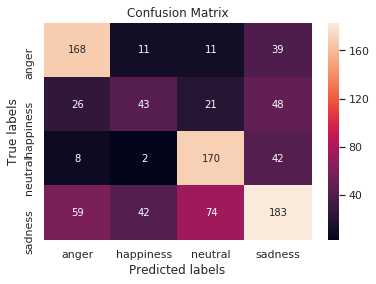


 Classification Report 
              precision    recall  f1-score   support

      anger       0.64      0.73      0.69       229
  happiness       0.44      0.31      0.36       138
    neutral       0.62      0.77      0.68       222
    sadness       0.59      0.51      0.55       358

avg / total       0.59      0.60      0.59       947
 

Train Epoch: 8 [0/3788 (0%)]	Loss: 1.151817

Train Epoch: 8 [1280/3788 (33%)]	Loss: 1.164265

Train Epoch: 8 [2560/3788 (67%)]	Loss: 1.238614


Train set: Average loss: 0.0092


Train Accuracy: 2160/3788 (57%)


Test set: Average loss: 0.0096, Accuracy: 543/947 (57%)



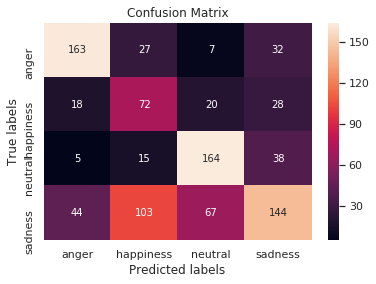


 Classification Report 
              precision    recall  f1-score   support

      anger       0.71      0.71      0.71       229
  happiness       0.33      0.52      0.41       138
    neutral       0.64      0.74      0.68       222
    sadness       0.60      0.40      0.48       358

avg / total       0.59      0.57      0.57       947
 

Train Epoch: 9 [0/3788 (0%)]	Loss: 1.118098

Train Epoch: 9 [1280/3788 (33%)]	Loss: 1.168594

Train Epoch: 9 [2560/3788 (67%)]	Loss: 1.197884


Train set: Average loss: 0.0092


Train Accuracy: 2167/3788 (57%)


Test set: Average loss: 0.0096, Accuracy: 529/947 (55%)



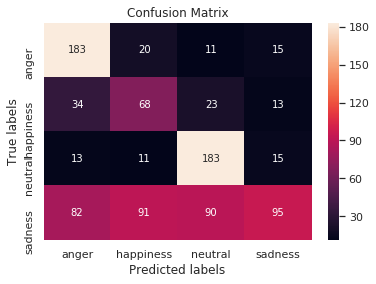


 Classification Report 
              precision    recall  f1-score   support

      anger       0.59      0.80      0.68       229
  happiness       0.36      0.49      0.41       138
    neutral       0.60      0.82      0.69       222
    sadness       0.69      0.27      0.38       358

avg / total       0.59      0.56      0.53       947
 

Train Epoch: 10 [0/3788 (0%)]	Loss: 1.154385

Train Epoch: 10 [1280/3788 (33%)]	Loss: 1.162793

Train Epoch: 10 [2560/3788 (67%)]	Loss: 1.128376


Train set: Average loss: 0.0091


Train Accuracy: 2161/3788 (57%)


Test set: Average loss: 0.0096, Accuracy: 574/947 (60%)



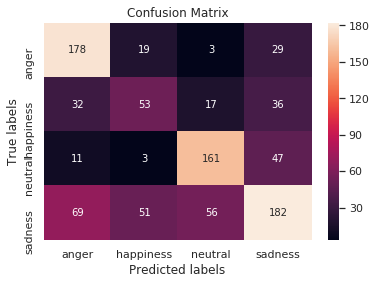


 Classification Report 
              precision    recall  f1-score   support

      anger       0.61      0.78      0.69       229
  happiness       0.42      0.38      0.40       138
    neutral       0.68      0.73      0.70       222
    sadness       0.62      0.51      0.56       358

avg / total       0.60      0.61      0.60       947
 

Train Epoch: 11 [0/3788 (0%)]	Loss: 1.131151

Train Epoch: 11 [1280/3788 (33%)]	Loss: 1.177039

Train Epoch: 11 [2560/3788 (67%)]	Loss: 1.150213


Train set: Average loss: 0.0091


Train Accuracy: 2226/3788 (58%)


Test set: Average loss: 0.0096, Accuracy: 563/947 (59%)



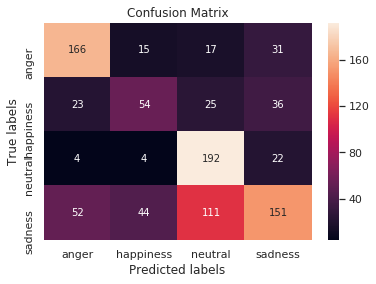


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.72      0.70       229
  happiness       0.46      0.39      0.42       138
    neutral       0.56      0.86      0.68       222
    sadness       0.63      0.42      0.51       358

avg / total       0.60      0.59      0.58       947
 

Train Epoch: 12 [0/3788 (0%)]	Loss: 1.105505

Train Epoch: 12 [1280/3788 (33%)]	Loss: 1.137776

Train Epoch: 12 [2560/3788 (67%)]	Loss: 1.128867


Train set: Average loss: 0.0091


Train Accuracy: 2200/3788 (58%)


Test set: Average loss: 0.0095, Accuracy: 547/947 (57%)



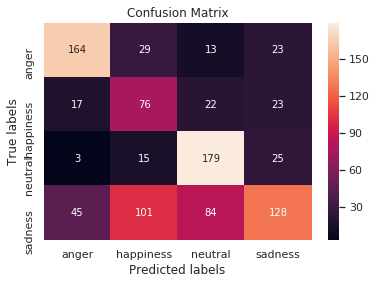


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.72      0.72       229
  happiness       0.34      0.55      0.42       138
    neutral       0.60      0.81      0.69       222
    sadness       0.64      0.36      0.46       358

avg / total       0.61      0.58      0.57       947
 

Train Epoch: 13 [0/3788 (0%)]	Loss: 1.154294

Train Epoch: 13 [1280/3788 (33%)]	Loss: 1.142134

Train Epoch: 13 [2560/3788 (67%)]	Loss: 1.094110


Train set: Average loss: 0.0091


Train Accuracy: 2249/3788 (59%)


Test set: Average loss: 0.0095, Accuracy: 551/947 (58%)



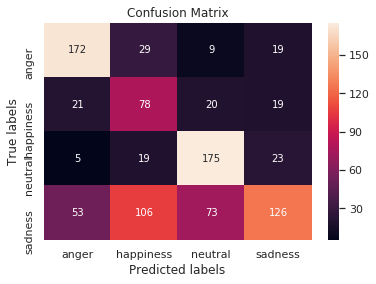


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.75      0.72       229
  happiness       0.34      0.57      0.42       138
    neutral       0.63      0.79      0.70       222
    sadness       0.67      0.35      0.46       358

avg / total       0.62      0.58      0.57       947
 

Train Epoch: 14 [0/3788 (0%)]	Loss: 1.184203

Train Epoch: 14 [1280/3788 (33%)]	Loss: 1.137676

Train Epoch: 14 [2560/3788 (67%)]	Loss: 1.196754


Train set: Average loss: 0.0090


Train Accuracy: 2211/3788 (58%)


Test set: Average loss: 0.0095, Accuracy: 580/947 (61%)



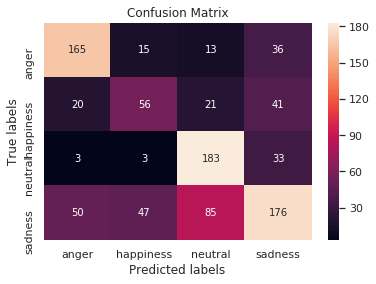


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.72      0.71       229
  happiness       0.46      0.41      0.43       138
    neutral       0.61      0.82      0.70       222
    sadness       0.62      0.49      0.55       358

avg / total       0.61      0.61      0.60       947
 

Train Epoch: 15 [0/3788 (0%)]	Loss: 1.175967

Train Epoch: 15 [1280/3788 (33%)]	Loss: 1.077379

Train Epoch: 15 [2560/3788 (67%)]	Loss: 1.111213


Train set: Average loss: 0.0090


Train Accuracy: 2200/3788 (58%)


Test set: Average loss: 0.0095, Accuracy: 581/947 (61%)



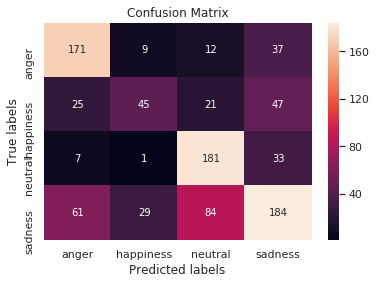


 Classification Report 
              precision    recall  f1-score   support

      anger       0.65      0.75      0.69       229
  happiness       0.54      0.33      0.41       138
    neutral       0.61      0.82      0.70       222
    sadness       0.61      0.51      0.56       358

avg / total       0.61      0.61      0.60       947
 

Train Epoch: 16 [0/3788 (0%)]	Loss: 1.180321

Train Epoch: 16 [1280/3788 (33%)]	Loss: 1.109015

Train Epoch: 16 [2560/3788 (67%)]	Loss: 1.147289


Train set: Average loss: 0.0090


Train Accuracy: 2192/3788 (57%)


Test set: Average loss: 0.0095, Accuracy: 594/947 (62%)



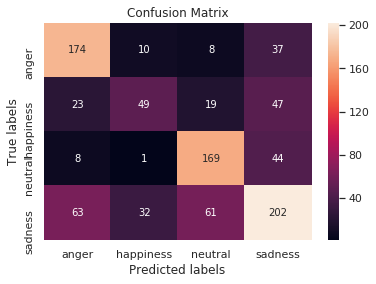


 Classification Report 
              precision    recall  f1-score   support

      anger       0.65      0.76      0.70       229
  happiness       0.53      0.36      0.43       138
    neutral       0.66      0.76      0.71       222
    sadness       0.61      0.56      0.59       358

avg / total       0.62      0.63      0.62       947
 

Train Epoch: 17 [0/3788 (0%)]	Loss: 1.181213

Train Epoch: 17 [1280/3788 (33%)]	Loss: 1.083160

Train Epoch: 17 [2560/3788 (67%)]	Loss: 1.134492


Train set: Average loss: 0.0090


Train Accuracy: 2268/3788 (59%)


Test set: Average loss: 0.0094, Accuracy: 568/947 (59%)



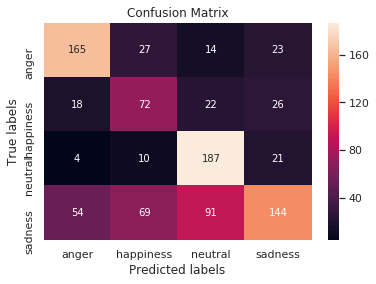


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.72      0.70       229
  happiness       0.40      0.52      0.46       138
    neutral       0.60      0.84      0.70       222
    sadness       0.67      0.40      0.50       358

avg / total       0.62      0.60      0.59       947
 

Train Epoch: 18 [0/3788 (0%)]	Loss: 1.117002

Train Epoch: 18 [1280/3788 (33%)]	Loss: 1.148187

Train Epoch: 18 [2560/3788 (67%)]	Loss: 1.109129


Train set: Average loss: 0.0090


Train Accuracy: 2230/3788 (58%)


Test set: Average loss: 0.0094, Accuracy: 596/947 (62%)



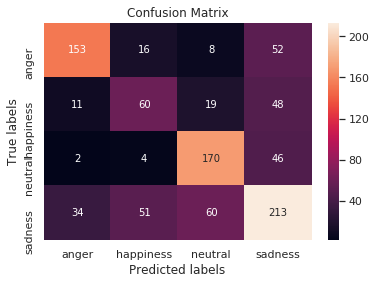


 Classification Report 
              precision    recall  f1-score   support

      anger       0.77      0.67      0.71       229
  happiness       0.46      0.43      0.45       138
    neutral       0.66      0.77      0.71       222
    sadness       0.59      0.59      0.59       358

avg / total       0.63      0.63      0.63       947
 

Train Epoch: 19 [0/3788 (0%)]	Loss: 1.151201

Train Epoch: 19 [1280/3788 (33%)]	Loss: 1.174901

Train Epoch: 19 [2560/3788 (67%)]	Loss: 1.118569


Train set: Average loss: 0.0089


Train Accuracy: 2266/3788 (59%)


Test set: Average loss: 0.0094, Accuracy: 562/947 (59%)



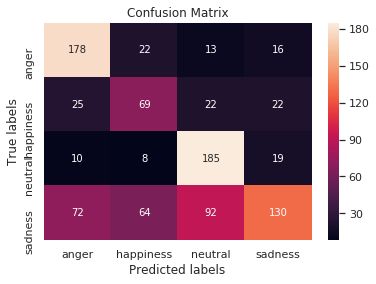


 Classification Report 
              precision    recall  f1-score   support

      anger       0.62      0.78      0.69       229
  happiness       0.42      0.50      0.46       138
    neutral       0.59      0.83      0.69       222
    sadness       0.70      0.36      0.48       358

avg / total       0.61      0.59      0.58       947
 

Train Epoch: 20 [0/3788 (0%)]	Loss: 1.100140

Train Epoch: 20 [1280/3788 (33%)]	Loss: 1.124641

Train Epoch: 20 [2560/3788 (67%)]	Loss: 1.151142


Train set: Average loss: 0.0090


Train Accuracy: 2213/3788 (58%)


Test set: Average loss: 0.0096, Accuracy: 551/947 (58%)



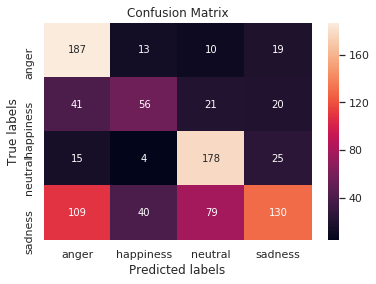


 Classification Report 
              precision    recall  f1-score   support

      anger       0.53      0.82      0.64       229
  happiness       0.50      0.41      0.45       138
    neutral       0.62      0.80      0.70       222
    sadness       0.67      0.36      0.47       358

avg / total       0.60      0.58      0.56       947
 

Train Epoch: 21 [0/3788 (0%)]	Loss: 1.103065

Train Epoch: 21 [1280/3788 (33%)]	Loss: 1.089294

Train Epoch: 21 [2560/3788 (67%)]	Loss: 1.128770


Train set: Average loss: 0.0090


Train Accuracy: 2229/3788 (58%)


Test set: Average loss: 0.0094, Accuracy: 578/947 (61%)



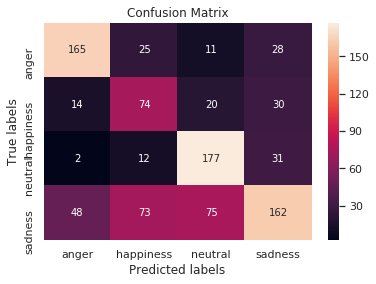


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.72      0.72       229
  happiness       0.40      0.54      0.46       138
    neutral       0.63      0.80      0.70       222
    sadness       0.65      0.45      0.53       358

avg / total       0.62      0.61      0.61       947
 

Train Epoch: 22 [0/3788 (0%)]	Loss: 1.099702

Train Epoch: 22 [1280/3788 (33%)]	Loss: 1.166197

Train Epoch: 22 [2560/3788 (67%)]	Loss: 1.152645


Train set: Average loss: 0.0089


Train Accuracy: 2253/3788 (59%)


Test set: Average loss: 0.0094, Accuracy: 579/947 (61%)



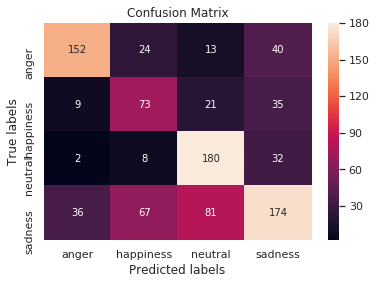


 Classification Report 
              precision    recall  f1-score   support

      anger       0.76      0.66      0.71       229
  happiness       0.42      0.53      0.47       138
    neutral       0.61      0.81      0.70       222
    sadness       0.62      0.49      0.54       358

avg / total       0.62      0.61      0.61       947
 

Train Epoch: 23 [0/3788 (0%)]	Loss: 1.162006

Train Epoch: 23 [1280/3788 (33%)]	Loss: 1.128879

Train Epoch: 23 [2560/3788 (67%)]	Loss: 1.054678


Train set: Average loss: 0.0089


Train Accuracy: 2269/3788 (59%)


Test set: Average loss: 0.0094, Accuracy: 599/947 (63%)



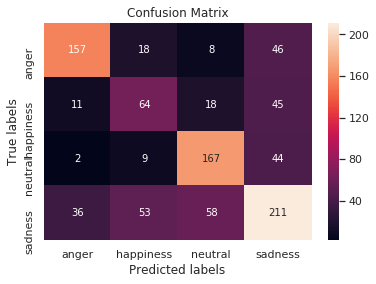


 Classification Report 
              precision    recall  f1-score   support

      anger       0.76      0.69      0.72       229
  happiness       0.44      0.46      0.45       138
    neutral       0.67      0.75      0.71       222
    sadness       0.61      0.59      0.60       358

avg / total       0.64      0.63      0.63       947
 

Train Epoch: 24 [0/3788 (0%)]	Loss: 1.103808

Train Epoch: 24 [1280/3788 (33%)]	Loss: 1.073452

Train Epoch: 24 [2560/3788 (67%)]	Loss: 1.090249


Train set: Average loss: 0.0089


Train Accuracy: 2208/3788 (58%)


Test set: Average loss: 0.0095, Accuracy: 571/947 (60%)



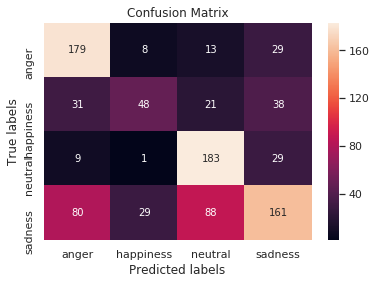


 Classification Report 
              precision    recall  f1-score   support

      anger       0.60      0.78      0.68       229
  happiness       0.56      0.35      0.43       138
    neutral       0.60      0.82      0.69       222
    sadness       0.63      0.45      0.52       358

avg / total       0.60      0.60      0.59       947
 

Train Epoch: 25 [0/3788 (0%)]	Loss: 1.113845

Train Epoch: 25 [1280/3788 (33%)]	Loss: 1.108932

Train Epoch: 25 [2560/3788 (67%)]	Loss: 1.128104


Train set: Average loss: 0.0089


Train Accuracy: 2271/3788 (59%)


Test set: Average loss: 0.0095, Accuracy: 584/947 (61%)



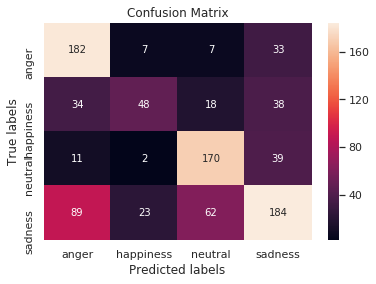


 Classification Report 
              precision    recall  f1-score   support

      anger       0.58      0.79      0.67       229
  happiness       0.60      0.35      0.44       138
    neutral       0.66      0.77      0.71       222
    sadness       0.63      0.51      0.56       358

avg / total       0.62      0.62      0.61       947
 

Train Epoch: 26 [0/3788 (0%)]	Loss: 1.119759

Train Epoch: 26 [1280/3788 (33%)]	Loss: 1.074800

Train Epoch: 26 [2560/3788 (67%)]	Loss: 1.156566


Train set: Average loss: 0.0089


Train Accuracy: 2251/3788 (59%)


Test set: Average loss: 0.0094, Accuracy: 568/947 (59%)



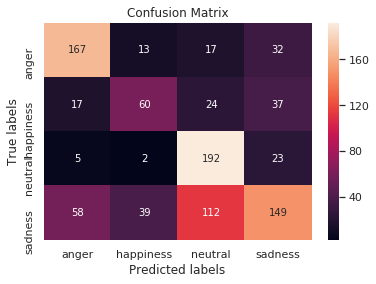


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.73      0.70       229
  happiness       0.53      0.43      0.48       138
    neutral       0.56      0.86      0.68       222
    sadness       0.62      0.42      0.50       358

avg / total       0.60      0.60      0.59       947
 

Train Epoch: 27 [0/3788 (0%)]	Loss: 1.094606

Train Epoch: 27 [1280/3788 (33%)]	Loss: 1.195901

Train Epoch: 27 [2560/3788 (67%)]	Loss: 1.232126


Train set: Average loss: 0.0089


Train Accuracy: 2277/3788 (60%)


Test set: Average loss: 0.0094, Accuracy: 594/947 (62%)



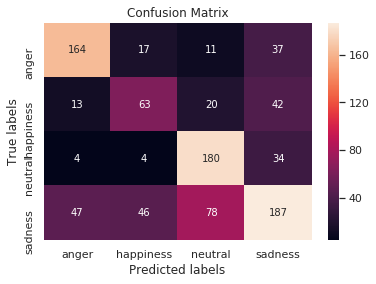


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.72      0.72       229
  happiness       0.48      0.46      0.47       138
    neutral       0.62      0.81      0.70       222
    sadness       0.62      0.52      0.57       358

avg / total       0.63      0.63      0.62       947
 

Train Epoch: 28 [0/3788 (0%)]	Loss: 1.074374

Train Epoch: 28 [1280/3788 (33%)]	Loss: 1.122755

Train Epoch: 28 [2560/3788 (67%)]	Loss: 1.139148


Train set: Average loss: 0.0089


Train Accuracy: 2290/3788 (60%)


Test set: Average loss: 0.0094, Accuracy: 589/947 (62%)



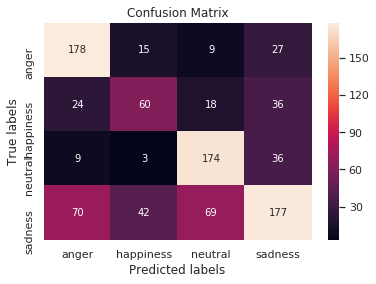


 Classification Report 
              precision    recall  f1-score   support

      anger       0.63      0.78      0.70       229
  happiness       0.50      0.43      0.47       138
    neutral       0.64      0.78      0.71       222
    sadness       0.64      0.49      0.56       358

avg / total       0.62      0.62      0.61       947
 

Train Epoch: 29 [0/3788 (0%)]	Loss: 1.059534

Train Epoch: 29 [1280/3788 (33%)]	Loss: 1.100046

Train Epoch: 29 [2560/3788 (67%)]	Loss: 1.122676


Train set: Average loss: 0.0089


Train Accuracy: 2326/3788 (61%)


Test set: Average loss: 0.0093, Accuracy: 581/947 (61%)



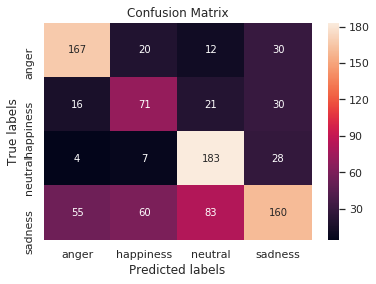


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.73      0.71       229
  happiness       0.45      0.51      0.48       138
    neutral       0.61      0.82      0.70       222
    sadness       0.65      0.45      0.53       358

avg / total       0.62      0.61      0.61       947
 

Train Epoch: 30 [0/3788 (0%)]	Loss: 1.135346

Train Epoch: 30 [1280/3788 (33%)]	Loss: 1.120689

Train Epoch: 30 [2560/3788 (67%)]	Loss: 1.068458


Train set: Average loss: 0.0089


Train Accuracy: 2235/3788 (59%)


Test set: Average loss: 0.0094, Accuracy: 545/947 (57%)



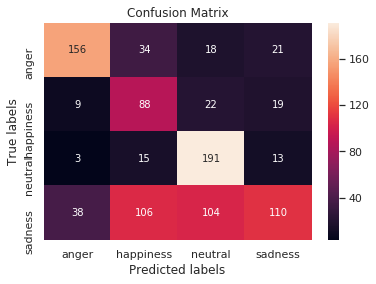


 Classification Report 
              precision    recall  f1-score   support

      anger       0.76      0.68      0.72       229
  happiness       0.36      0.64      0.46       138
    neutral       0.57      0.86      0.69       222
    sadness       0.67      0.31      0.42       358

avg / total       0.62      0.58      0.56       947
 

Train Epoch: 31 [0/3788 (0%)]	Loss: 1.147873

Train Epoch: 31 [1280/3788 (33%)]	Loss: 1.147191

Train Epoch: 31 [2560/3788 (67%)]	Loss: 1.139306


Train set: Average loss: 0.0089


Train Accuracy: 2260/3788 (59%)


Test set: Average loss: 0.0093, Accuracy: 581/947 (61%)



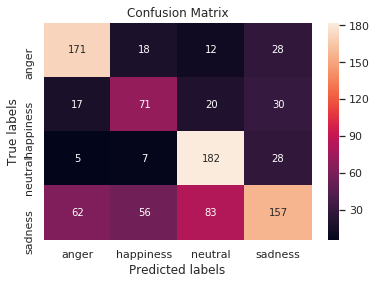


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.75      0.71       229
  happiness       0.47      0.51      0.49       138
    neutral       0.61      0.82      0.70       222
    sadness       0.65      0.44      0.52       358

avg / total       0.62      0.61      0.60       947
 

Train Epoch: 32 [0/3788 (0%)]	Loss: 1.164550

Train Epoch: 32 [1280/3788 (33%)]	Loss: 1.082897

Train Epoch: 32 [2560/3788 (67%)]	Loss: 1.077878


Train set: Average loss: 0.0089


Train Accuracy: 2288/3788 (60%)


Test set: Average loss: 0.0093, Accuracy: 588/947 (62%)



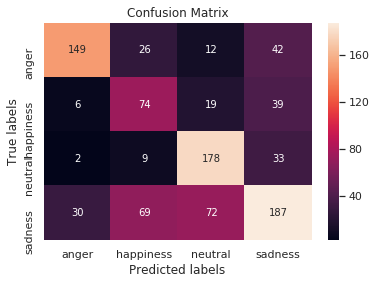


 Classification Report 
              precision    recall  f1-score   support

      anger       0.80      0.65      0.72       229
  happiness       0.42      0.54      0.47       138
    neutral       0.63      0.80      0.71       222
    sadness       0.62      0.52      0.57       358

avg / total       0.64      0.62      0.62       947
 

Train Epoch: 33 [0/3788 (0%)]	Loss: 1.134656

Train Epoch: 33 [1280/3788 (33%)]	Loss: 1.143582

Train Epoch: 33 [2560/3788 (67%)]	Loss: 1.212627


Train set: Average loss: 0.0089


Train Accuracy: 2247/3788 (59%)


Test set: Average loss: 0.0095, Accuracy: 585/947 (61%)



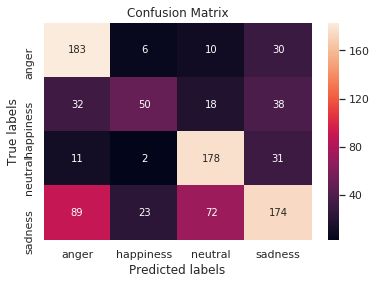


 Classification Report 
              precision    recall  f1-score   support

      anger       0.58      0.80      0.67       229
  happiness       0.62      0.36      0.46       138
    neutral       0.64      0.80      0.71       222
    sadness       0.64      0.49      0.55       358

avg / total       0.62      0.62      0.60       947
 

Train Epoch: 34 [0/3788 (0%)]	Loss: 1.060445

Train Epoch: 34 [1280/3788 (33%)]	Loss: 1.132959

Train Epoch: 34 [2560/3788 (67%)]	Loss: 1.156258


Train set: Average loss: 0.0089


Train Accuracy: 2231/3788 (58%)


Test set: Average loss: 0.0094, Accuracy: 591/947 (62%)



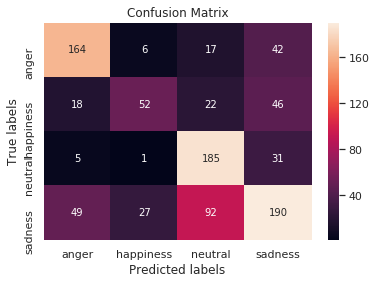


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.72      0.71       229
  happiness       0.60      0.38      0.46       138
    neutral       0.59      0.83      0.69       222
    sadness       0.61      0.53      0.57       358

avg / total       0.63      0.62      0.61       947
 

Train Epoch: 35 [0/3788 (0%)]	Loss: 1.039425

Train Epoch: 35 [1280/3788 (33%)]	Loss: 1.124650

Train Epoch: 35 [2560/3788 (67%)]	Loss: 1.185824


Train set: Average loss: 0.0088


Train Accuracy: 2335/3788 (61%)


Test set: Average loss: 0.0094, Accuracy: 545/947 (57%)



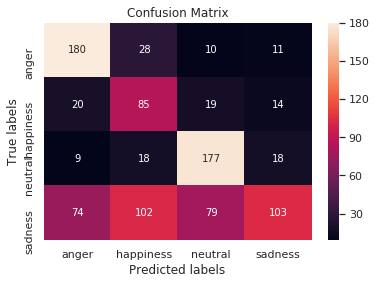


 Classification Report 
              precision    recall  f1-score   support

      anger       0.64      0.79      0.70       229
  happiness       0.36      0.62      0.46       138
    neutral       0.62      0.80      0.70       222
    sadness       0.71      0.29      0.41       358

avg / total       0.62      0.58      0.55       947
 

Train Epoch: 36 [0/3788 (0%)]	Loss: 1.067241

Train Epoch: 36 [1280/3788 (33%)]	Loss: 1.128785

Train Epoch: 36 [2560/3788 (67%)]	Loss: 1.073358


Train set: Average loss: 0.0089


Train Accuracy: 2251/3788 (59%)


Test set: Average loss: 0.0095, Accuracy: 608/947 (64%)



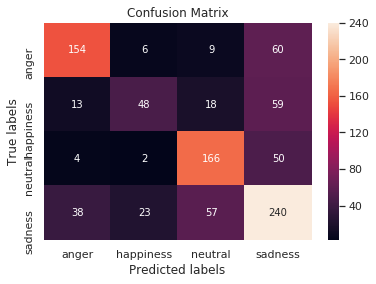


 Classification Report 
              precision    recall  f1-score   support

      anger       0.74      0.67      0.70       229
  happiness       0.61      0.35      0.44       138
    neutral       0.66      0.75      0.70       222
    sadness       0.59      0.67      0.63       358

avg / total       0.64      0.64      0.64       947
 

Train Epoch: 37 [0/3788 (0%)]	Loss: 1.136857

Train Epoch: 37 [1280/3788 (33%)]	Loss: 1.062811

Train Epoch: 37 [2560/3788 (67%)]	Loss: 1.189602


Train set: Average loss: 0.0089


Train Accuracy: 2282/3788 (60%)


Test set: Average loss: 0.0094, Accuracy: 591/947 (62%)



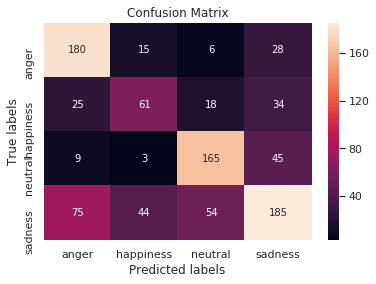


 Classification Report 
              precision    recall  f1-score   support

      anger       0.62      0.79      0.69       229
  happiness       0.50      0.44      0.47       138
    neutral       0.68      0.74      0.71       222
    sadness       0.63      0.52      0.57       358

avg / total       0.62      0.62      0.62       947
 

Train Epoch: 38 [0/3788 (0%)]	Loss: 1.048013

Train Epoch: 38 [1280/3788 (33%)]	Loss: 1.118832

Train Epoch: 38 [2560/3788 (67%)]	Loss: 1.108335


Train set: Average loss: 0.0088


Train Accuracy: 2337/3788 (61%)


Test set: Average loss: 0.0093, Accuracy: 587/947 (61%)



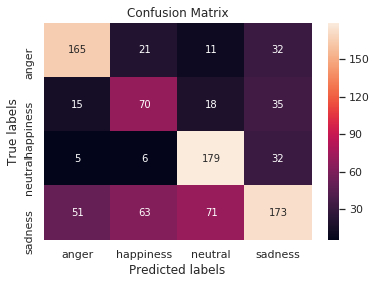


 Classification Report 
              precision    recall  f1-score   support

      anger       0.70      0.72      0.71       229
  happiness       0.44      0.51      0.47       138
    neutral       0.64      0.81      0.71       222
    sadness       0.64      0.48      0.55       358

avg / total       0.62      0.62      0.62       947
 

Train Epoch: 39 [0/3788 (0%)]	Loss: 1.033114

Train Epoch: 39 [1280/3788 (33%)]	Loss: 1.115222

Train Epoch: 39 [2560/3788 (67%)]	Loss: 1.137780


Train set: Average loss: 0.0088


Train Accuracy: 2310/3788 (60%)


Test set: Average loss: 0.0093, Accuracy: 574/947 (60%)



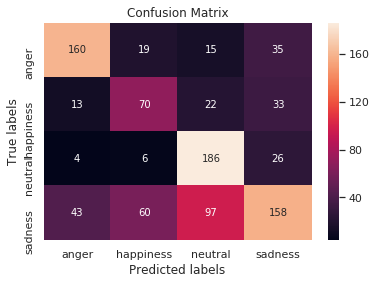


 Classification Report 
              precision    recall  f1-score   support

      anger       0.73      0.70      0.71       229
  happiness       0.45      0.51      0.48       138
    neutral       0.58      0.84      0.69       222
    sadness       0.63      0.44      0.52       358

avg / total       0.61      0.61      0.60       947
 

Train Epoch: 40 [0/3788 (0%)]	Loss: 1.145867

Train Epoch: 40 [1280/3788 (33%)]	Loss: 1.096846

Train Epoch: 40 [2560/3788 (67%)]	Loss: 1.132771


Train set: Average loss: 0.0088


Train Accuracy: 2332/3788 (61%)


Test set: Average loss: 0.0093, Accuracy: 578/947 (61%)



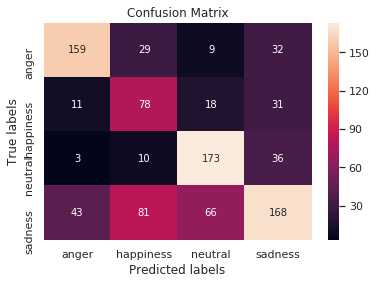


 Classification Report 
              precision    recall  f1-score   support

      anger       0.74      0.69      0.71       229
  happiness       0.39      0.57      0.46       138
    neutral       0.65      0.78      0.71       222
    sadness       0.63      0.47      0.54       358

avg / total       0.63      0.61      0.61       947
 

Train Epoch: 41 [0/3788 (0%)]	Loss: 1.088800

Train Epoch: 41 [1280/3788 (33%)]	Loss: 1.048104

Train Epoch: 41 [2560/3788 (67%)]	Loss: 1.148545


Train set: Average loss: 0.0088


Train Accuracy: 2342/3788 (61%)


Test set: Average loss: 0.0093, Accuracy: 578/947 (61%)



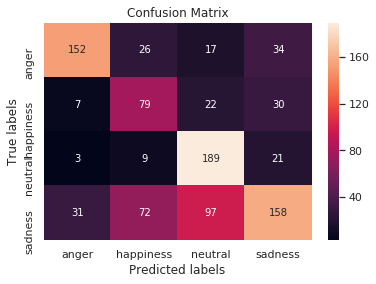


 Classification Report 
              precision    recall  f1-score   support

      anger       0.79      0.66      0.72       229
  happiness       0.42      0.57      0.49       138
    neutral       0.58      0.85      0.69       222
    sadness       0.65      0.44      0.53       358

avg / total       0.63      0.61      0.61       947
 

Train Epoch: 42 [0/3788 (0%)]	Loss: 1.098089

Train Epoch: 42 [1280/3788 (33%)]	Loss: 1.139421

Train Epoch: 42 [2560/3788 (67%)]	Loss: 1.100435


Train set: Average loss: 0.0088


Train Accuracy: 2363/3788 (62%)


Test set: Average loss: 0.0094, Accuracy: 559/947 (59%)



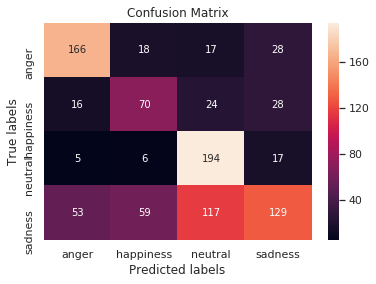


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.72      0.71       229
  happiness       0.46      0.51      0.48       138
    neutral       0.55      0.87      0.68       222
    sadness       0.64      0.36      0.46       358

avg / total       0.60      0.59      0.57       947
 

Train Epoch: 43 [0/3788 (0%)]	Loss: 1.145188

Train Epoch: 43 [1280/3788 (33%)]	Loss: 1.078331

Train Epoch: 43 [2560/3788 (67%)]	Loss: 1.127347


Train set: Average loss: 0.0088


Train Accuracy: 2280/3788 (60%)


Test set: Average loss: 0.0094, Accuracy: 585/947 (61%)



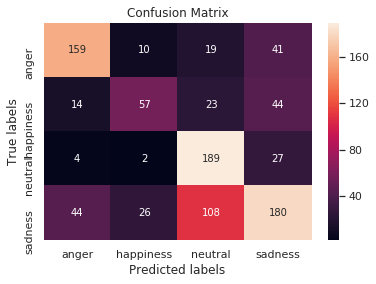


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.69      0.71       229
  happiness       0.60      0.41      0.49       138
    neutral       0.56      0.85      0.67       222
    sadness       0.62      0.50      0.55       358

avg / total       0.63      0.62      0.61       947
 

Train Epoch: 44 [0/3788 (0%)]	Loss: 1.112351

Train Epoch: 44 [1280/3788 (33%)]	Loss: 1.061280

Train Epoch: 44 [2560/3788 (67%)]	Loss: 1.117776


Train set: Average loss: 0.0088


Train Accuracy: 2321/3788 (61%)


Test set: Average loss: 0.0093, Accuracy: 586/947 (61%)



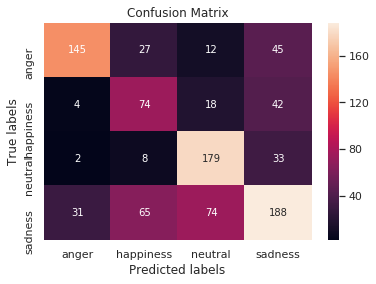


 Classification Report 
              precision    recall  f1-score   support

      anger       0.80      0.63      0.71       229
  happiness       0.43      0.54      0.47       138
    neutral       0.63      0.81      0.71       222
    sadness       0.61      0.53      0.56       358

avg / total       0.63      0.62      0.62       947
 

Train Epoch: 45 [0/3788 (0%)]	Loss: 1.115348

Train Epoch: 45 [1280/3788 (33%)]	Loss: 1.179457

Train Epoch: 45 [2560/3788 (67%)]	Loss: 1.160668


Train set: Average loss: 0.0088


Train Accuracy: 2311/3788 (61%)


Test set: Average loss: 0.0094, Accuracy: 586/947 (61%)



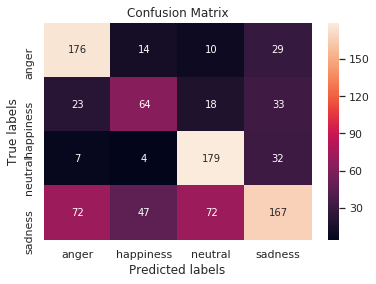


 Classification Report 
              precision    recall  f1-score   support

      anger       0.63      0.77      0.69       229
  happiness       0.50      0.46      0.48       138
    neutral       0.64      0.81      0.71       222
    sadness       0.64      0.47      0.54       358

avg / total       0.62      0.62      0.61       947
 

Train Epoch: 46 [0/3788 (0%)]	Loss: 1.100461

Train Epoch: 46 [1280/3788 (33%)]	Loss: 1.125047

Train Epoch: 46 [2560/3788 (67%)]	Loss: 1.093848


Train set: Average loss: 0.0088


Train Accuracy: 2306/3788 (60%)


Test set: Average loss: 0.0093, Accuracy: 575/947 (60%)



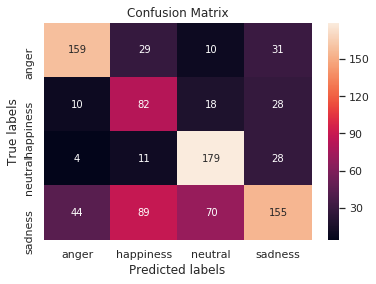


 Classification Report 
              precision    recall  f1-score   support

      anger       0.73      0.69      0.71       229
  happiness       0.39      0.59      0.47       138
    neutral       0.65      0.81      0.72       222
    sadness       0.64      0.43      0.52       358

avg / total       0.63      0.61      0.60       947
 

Train Epoch: 47 [0/3788 (0%)]	Loss: 1.090111

Train Epoch: 47 [1280/3788 (33%)]	Loss: 1.065526

Train Epoch: 47 [2560/3788 (67%)]	Loss: 1.165376


Train set: Average loss: 0.0088


Train Accuracy: 2347/3788 (61%)


Test set: Average loss: 0.0095, Accuracy: 598/947 (63%)



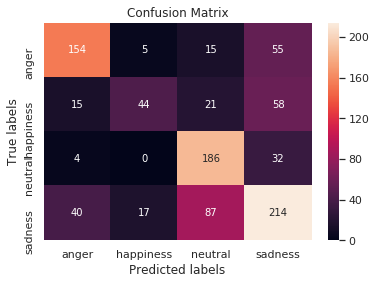


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.67      0.70       229
  happiness       0.67      0.32      0.43       138
    neutral       0.60      0.84      0.70       222
    sadness       0.60      0.60      0.60       358

avg / total       0.64      0.63      0.62       947
 

Train Epoch: 48 [0/3788 (0%)]	Loss: 1.105237

Train Epoch: 48 [1280/3788 (33%)]	Loss: 1.032892

Train Epoch: 48 [2560/3788 (67%)]	Loss: 1.124130


Train set: Average loss: 0.0088


Train Accuracy: 2358/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 597/947 (63%)



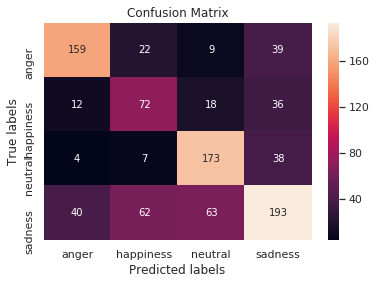


 Classification Report 
              precision    recall  f1-score   support

      anger       0.74      0.69      0.72       229
  happiness       0.44      0.52      0.48       138
    neutral       0.66      0.78      0.71       222
    sadness       0.63      0.54      0.58       358

avg / total       0.64      0.63      0.63       947
 

Train Epoch: 49 [0/3788 (0%)]	Loss: 1.078076

Train Epoch: 49 [1280/3788 (33%)]	Loss: 1.180062

Train Epoch: 49 [2560/3788 (67%)]	Loss: 1.214477


Train set: Average loss: 0.0088


Train Accuracy: 2340/3788 (61%)


Test set: Average loss: 0.0095, Accuracy: 563/947 (59%)



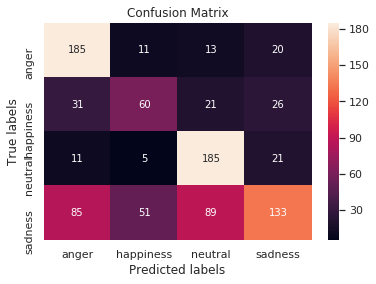


 Classification Report 
              precision    recall  f1-score   support

      anger       0.59      0.81      0.68       229
  happiness       0.47      0.43      0.45       138
    neutral       0.60      0.83      0.70       222
    sadness       0.67      0.37      0.48       358

avg / total       0.60      0.59      0.58       947
 

Train Epoch: 50 [0/3788 (0%)]	Loss: 1.162209

Train Epoch: 50 [1280/3788 (33%)]	Loss: 1.130197

Train Epoch: 50 [2560/3788 (67%)]	Loss: 1.137062


Train set: Average loss: 0.0088


Train Accuracy: 2335/3788 (61%)


Test set: Average loss: 0.0093, Accuracy: 592/947 (62%)



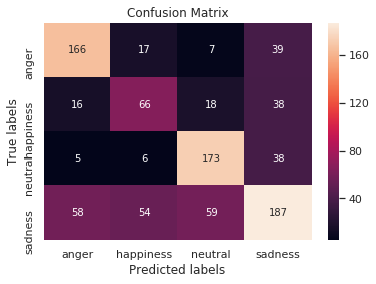


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.72      0.70       229
  happiness       0.46      0.48      0.47       138
    neutral       0.67      0.78      0.72       222
    sadness       0.62      0.52      0.57       358

avg / total       0.62      0.63      0.62       947
 

Train Epoch: 51 [0/3788 (0%)]	Loss: 1.076098

Train Epoch: 51 [1280/3788 (33%)]	Loss: 1.074398

Train Epoch: 51 [2560/3788 (67%)]	Loss: 1.086401


Train set: Average loss: 0.0088


Train Accuracy: 2339/3788 (61%)


Test set: Average loss: 0.0094, Accuracy: 558/947 (58%)



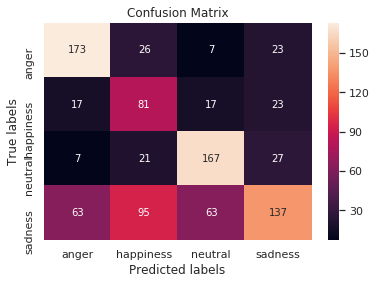


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.76      0.71       229
  happiness       0.36      0.59      0.45       138
    neutral       0.66      0.75      0.70       222
    sadness       0.65      0.38      0.48       358

avg / total       0.61      0.59      0.58       947
 

Train Epoch: 52 [0/3788 (0%)]	Loss: 1.102927

Train Epoch: 52 [1280/3788 (33%)]	Loss: 1.104800

Train Epoch: 52 [2560/3788 (67%)]	Loss: 1.073666


Train set: Average loss: 0.0088


Train Accuracy: 2335/3788 (61%)


Test set: Average loss: 0.0094, Accuracy: 563/947 (59%)



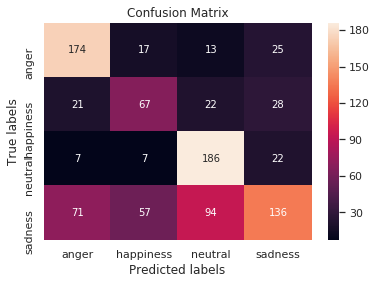


 Classification Report 
              precision    recall  f1-score   support

      anger       0.64      0.76      0.69       229
  happiness       0.45      0.49      0.47       138
    neutral       0.59      0.84      0.69       222
    sadness       0.64      0.38      0.48       358

avg / total       0.60      0.59      0.58       947
 

Train Epoch: 53 [0/3788 (0%)]	Loss: 1.072887

Train Epoch: 53 [1280/3788 (33%)]	Loss: 1.103948

Train Epoch: 53 [2560/3788 (67%)]	Loss: 1.115918


Train set: Average loss: 0.0088


Train Accuracy: 2330/3788 (61%)


Test set: Average loss: 0.0093, Accuracy: 585/947 (61%)



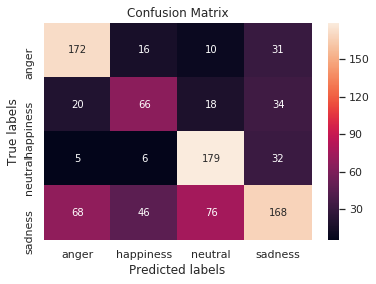


 Classification Report 
              precision    recall  f1-score   support

      anger       0.65      0.75      0.70       229
  happiness       0.49      0.48      0.49       138
    neutral       0.63      0.81      0.71       222
    sadness       0.63      0.47      0.54       358

avg / total       0.62      0.62      0.61       947
 

Train Epoch: 54 [0/3788 (0%)]	Loss: 1.131837

Train Epoch: 54 [1280/3788 (33%)]	Loss: 1.152004

Train Epoch: 54 [2560/3788 (67%)]	Loss: 1.114879


Train set: Average loss: 0.0088


Train Accuracy: 2322/3788 (61%)


Test set: Average loss: 0.0094, Accuracy: 584/947 (61%)



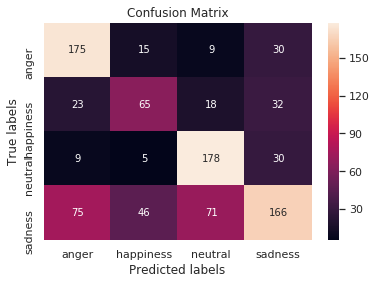


 Classification Report 
              precision    recall  f1-score   support

      anger       0.62      0.76      0.68       229
  happiness       0.50      0.47      0.48       138
    neutral       0.64      0.80      0.71       222
    sadness       0.64      0.46      0.54       358

avg / total       0.62      0.62      0.61       947
 

Train Epoch: 55 [0/3788 (0%)]	Loss: 1.085571

Train Epoch: 55 [1280/3788 (33%)]	Loss: 1.117777

Train Epoch: 55 [2560/3788 (67%)]	Loss: 1.051609


Train set: Average loss: 0.0088


Train Accuracy: 2359/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 602/947 (63%)



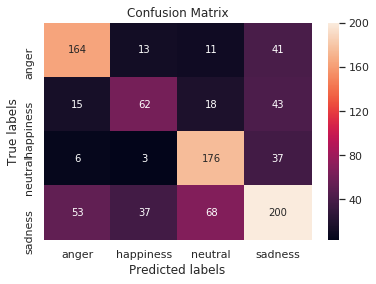


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.72      0.70       229
  happiness       0.54      0.45      0.49       138
    neutral       0.64      0.79      0.71       222
    sadness       0.62      0.56      0.59       358

avg / total       0.63      0.64      0.63       947
 

Train Epoch: 56 [0/3788 (0%)]	Loss: 1.083715

Train Epoch: 56 [1280/3788 (33%)]	Loss: 1.085440

Train Epoch: 56 [2560/3788 (67%)]	Loss: 1.059064


Train set: Average loss: 0.0087


Train Accuracy: 2374/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 602/947 (63%)



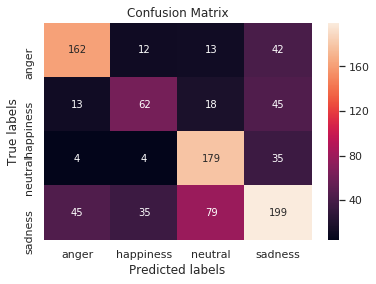


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.71      0.72       229
  happiness       0.55      0.45      0.49       138
    neutral       0.62      0.81      0.70       222
    sadness       0.62      0.56      0.59       358

avg / total       0.63      0.64      0.63       947
 

Train Epoch: 57 [0/3788 (0%)]	Loss: 1.169412

Train Epoch: 57 [1280/3788 (33%)]	Loss: 1.083360

Train Epoch: 57 [2560/3788 (67%)]	Loss: 1.093035


Train set: Average loss: 0.0088


Train Accuracy: 2360/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 565/947 (59%)



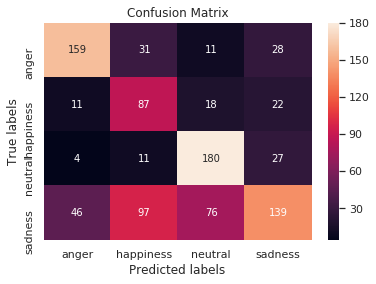


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.69      0.71       229
  happiness       0.38      0.63      0.48       138
    neutral       0.63      0.81      0.71       222
    sadness       0.64      0.39      0.48       358

avg / total       0.62      0.60      0.59       947
 

Train Epoch: 58 [0/3788 (0%)]	Loss: 1.040982

Train Epoch: 58 [1280/3788 (33%)]	Loss: 1.065412

Train Epoch: 58 [2560/3788 (67%)]	Loss: 1.108406


Train set: Average loss: 0.0088


Train Accuracy: 2351/3788 (62%)


Test set: Average loss: 0.0095, Accuracy: 584/947 (61%)



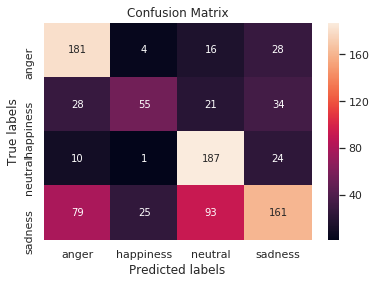


 Classification Report 
              precision    recall  f1-score   support

      anger       0.61      0.79      0.69       229
  happiness       0.65      0.40      0.49       138
    neutral       0.59      0.84      0.69       222
    sadness       0.65      0.45      0.53       358

avg / total       0.63      0.62      0.60       947
 

Train Epoch: 59 [0/3788 (0%)]	Loss: 1.140178

Train Epoch: 59 [1280/3788 (33%)]	Loss: 1.162346

Train Epoch: 59 [2560/3788 (67%)]	Loss: 1.141104


Train set: Average loss: 0.0088


Train Accuracy: 2307/3788 (60%)


Test set: Average loss: 0.0093, Accuracy: 580/947 (61%)



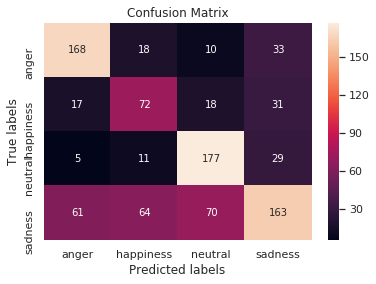


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.73      0.70       229
  happiness       0.44      0.52      0.48       138
    neutral       0.64      0.80      0.71       222
    sadness       0.64      0.46      0.53       358

avg / total       0.62      0.61      0.61       947
 

Train Epoch: 60 [0/3788 (0%)]	Loss: 1.114205

Train Epoch: 60 [1280/3788 (33%)]	Loss: 1.099204

Train Epoch: 60 [2560/3788 (67%)]	Loss: 1.093372


Train set: Average loss: 0.0088


Train Accuracy: 2331/3788 (61%)


Test set: Average loss: 0.0094, Accuracy: 585/947 (61%)



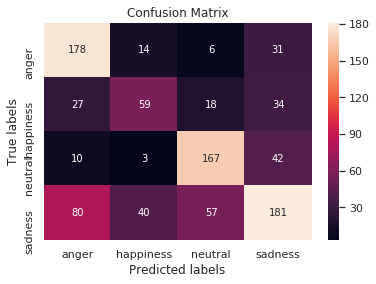


 Classification Report 
              precision    recall  f1-score   support

      anger       0.60      0.78      0.68       229
  happiness       0.51      0.43      0.46       138
    neutral       0.67      0.75      0.71       222
    sadness       0.63      0.51      0.56       358

avg / total       0.62      0.62      0.61       947
 

Train Epoch: 61 [0/3788 (0%)]	Loss: 1.057179

Train Epoch: 61 [1280/3788 (33%)]	Loss: 1.050203

Train Epoch: 61 [2560/3788 (67%)]	Loss: 1.188309


Train set: Average loss: 0.0087


Train Accuracy: 2368/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 579/947 (61%)



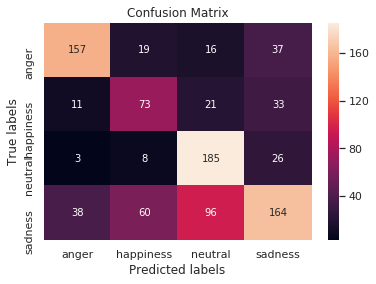


 Classification Report 
              precision    recall  f1-score   support

      anger       0.75      0.69      0.72       229
  happiness       0.46      0.53      0.49       138
    neutral       0.58      0.83      0.69       222
    sadness       0.63      0.46      0.53       358

avg / total       0.62      0.61      0.61       947
 

Train Epoch: 62 [0/3788 (0%)]	Loss: 1.139227

Train Epoch: 62 [1280/3788 (33%)]	Loss: 1.119749

Train Epoch: 62 [2560/3788 (67%)]	Loss: 1.144191


Train set: Average loss: 0.0088


Train Accuracy: 2328/3788 (61%)


Test set: Average loss: 0.0093, Accuracy: 591/947 (62%)



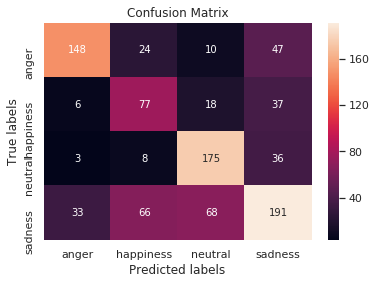


 Classification Report 
              precision    recall  f1-score   support

      anger       0.78      0.65      0.71       229
  happiness       0.44      0.56      0.49       138
    neutral       0.65      0.79      0.71       222
    sadness       0.61      0.53      0.57       358

avg / total       0.64      0.62      0.62       947
 

Train Epoch: 63 [0/3788 (0%)]	Loss: 1.096091

Train Epoch: 63 [1280/3788 (33%)]	Loss: 1.144078

Train Epoch: 63 [2560/3788 (67%)]	Loss: 1.098014


Train set: Average loss: 0.0088


Train Accuracy: 2345/3788 (61%)


Test set: Average loss: 0.0093, Accuracy: 590/947 (62%)



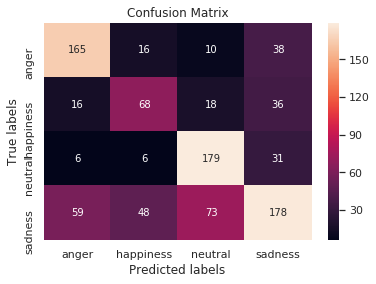


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.72      0.69       229
  happiness       0.49      0.49      0.49       138
    neutral       0.64      0.81      0.71       222
    sadness       0.63      0.50      0.56       358

avg / total       0.62      0.62      0.62       947
 

Train Epoch: 64 [0/3788 (0%)]	Loss: 1.105803

Train Epoch: 64 [1280/3788 (33%)]	Loss: 1.043808

Train Epoch: 64 [2560/3788 (67%)]	Loss: 1.109351


Train set: Average loss: 0.0087


Train Accuracy: 2367/3788 (62%)


Test set: Average loss: 0.0094, Accuracy: 553/947 (58%)



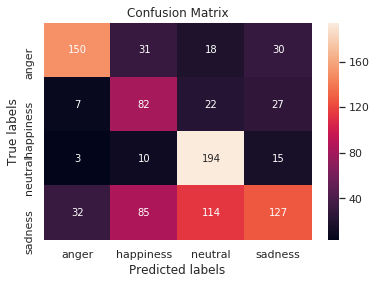


 Classification Report 
              precision    recall  f1-score   support

      anger       0.78      0.66      0.71       229
  happiness       0.39      0.59      0.47       138
    neutral       0.56      0.87      0.68       222
    sadness       0.64      0.35      0.46       358

avg / total       0.62      0.58      0.57       947
 

Train Epoch: 65 [0/3788 (0%)]	Loss: 1.102950

Train Epoch: 65 [1280/3788 (33%)]	Loss: 1.040146

Train Epoch: 65 [2560/3788 (67%)]	Loss: 1.111159


Train set: Average loss: 0.0088


Train Accuracy: 2331/3788 (61%)


Test set: Average loss: 0.0093, Accuracy: 602/947 (63%)



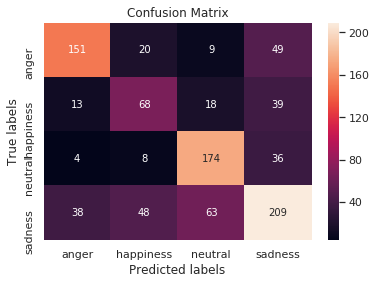


 Classification Report 
              precision    recall  f1-score   support

      anger       0.73      0.66      0.69       229
  happiness       0.47      0.49      0.48       138
    neutral       0.66      0.78      0.72       222
    sadness       0.63      0.58      0.60       358

avg / total       0.64      0.64      0.63       947
 

Train Epoch: 66 [0/3788 (0%)]	Loss: 1.094872

Train Epoch: 66 [1280/3788 (33%)]	Loss: 1.085633

Train Epoch: 66 [2560/3788 (67%)]	Loss: 1.147768


Train set: Average loss: 0.0087


Train Accuracy: 2355/3788 (62%)


Test set: Average loss: 0.0094, Accuracy: 577/947 (60%)



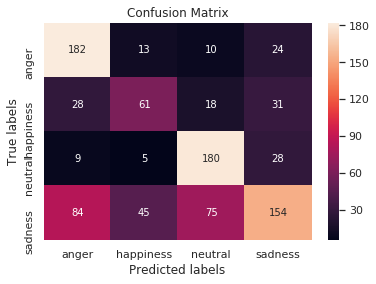


 Classification Report 
              precision    recall  f1-score   support

      anger       0.60      0.79      0.68       229
  happiness       0.49      0.44      0.47       138
    neutral       0.64      0.81      0.71       222
    sadness       0.65      0.43      0.52       358

avg / total       0.61      0.61      0.60       947
 

Train Epoch: 67 [0/3788 (0%)]	Loss: 1.070712

Train Epoch: 67 [1280/3788 (33%)]	Loss: 1.081351

Train Epoch: 67 [2560/3788 (67%)]	Loss: 1.111749


Train set: Average loss: 0.0088


Train Accuracy: 2347/3788 (61%)


Test set: Average loss: 0.0093, Accuracy: 608/947 (64%)



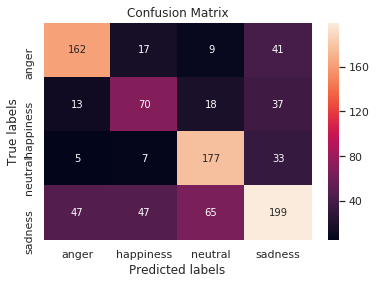


 Classification Report 
              precision    recall  f1-score   support

      anger       0.71      0.71      0.71       229
  happiness       0.50      0.51      0.50       138
    neutral       0.66      0.80      0.72       222
    sadness       0.64      0.56      0.60       358

avg / total       0.64      0.64      0.64       947
 

Train Epoch: 68 [0/3788 (0%)]	Loss: 1.154688

Train Epoch: 68 [1280/3788 (33%)]	Loss: 1.063131

Train Epoch: 68 [2560/3788 (67%)]	Loss: 1.060843


Train set: Average loss: 0.0087


Train Accuracy: 2371/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 576/947 (60%)



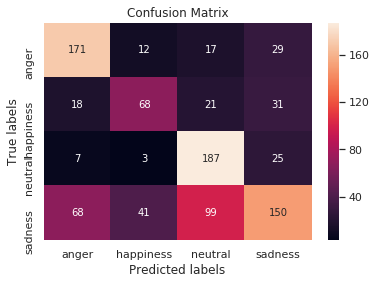


 Classification Report 
              precision    recall  f1-score   support

      anger       0.65      0.75      0.69       229
  happiness       0.55      0.49      0.52       138
    neutral       0.58      0.84      0.68       222
    sadness       0.64      0.42      0.51       358

avg / total       0.61      0.61      0.60       947
 

Train Epoch: 69 [0/3788 (0%)]	Loss: 1.116406

Train Epoch: 69 [1280/3788 (33%)]	Loss: 1.193432

Train Epoch: 69 [2560/3788 (67%)]	Loss: 1.062202


Train set: Average loss: 0.0087


Train Accuracy: 2357/3788 (62%)


Test set: Average loss: 0.0094, Accuracy: 587/947 (61%)



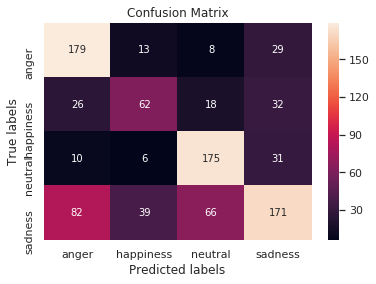


 Classification Report 
              precision    recall  f1-score   support

      anger       0.60      0.78      0.68       229
  happiness       0.52      0.45      0.48       138
    neutral       0.66      0.79      0.72       222
    sadness       0.65      0.48      0.55       358

avg / total       0.62      0.62      0.61       947
 

Train Epoch: 70 [0/3788 (0%)]	Loss: 1.056382

Train Epoch: 70 [1280/3788 (33%)]	Loss: 1.105238

Train Epoch: 70 [2560/3788 (67%)]	Loss: 1.102223


Train set: Average loss: 0.0087


Train Accuracy: 2310/3788 (60%)


Test set: Average loss: 0.0093, Accuracy: 604/947 (63%)



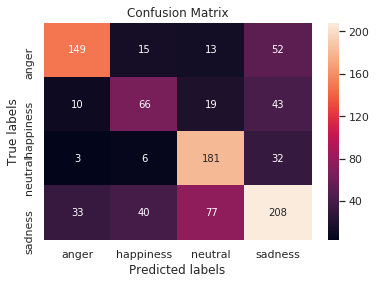


 Classification Report 
              precision    recall  f1-score   support

      anger       0.76      0.65      0.70       229
  happiness       0.52      0.48      0.50       138
    neutral       0.62      0.82      0.71       222
    sadness       0.62      0.58      0.60       358

avg / total       0.64      0.64      0.64       947
 

Train Epoch: 71 [0/3788 (0%)]	Loss: 1.043927

Train Epoch: 71 [1280/3788 (33%)]	Loss: 1.092513

Train Epoch: 71 [2560/3788 (67%)]	Loss: 1.070292


Train set: Average loss: 0.0087


Train Accuracy: 2391/3788 (63%)


Test set: Average loss: 0.0092, Accuracy: 582/947 (61%)



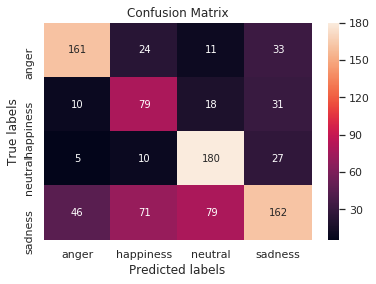


 Classification Report 
              precision    recall  f1-score   support

      anger       0.73      0.70      0.71       229
  happiness       0.43      0.57      0.49       138
    neutral       0.62      0.81      0.71       222
    sadness       0.64      0.45      0.53       358

avg / total       0.63      0.61      0.61       947
 

Train Epoch: 72 [0/3788 (0%)]	Loss: 1.070737

Train Epoch: 72 [1280/3788 (33%)]	Loss: 1.075040

Train Epoch: 72 [2560/3788 (67%)]	Loss: 1.078591


Train set: Average loss: 0.0087


Train Accuracy: 2366/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 581/947 (61%)



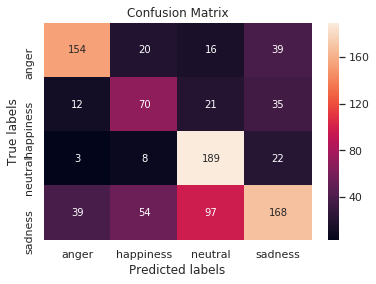


 Classification Report 
              precision    recall  f1-score   support

      anger       0.74      0.67      0.70       229
  happiness       0.46      0.51      0.48       138
    neutral       0.59      0.85      0.69       222
    sadness       0.64      0.47      0.54       358

avg / total       0.62      0.61      0.61       947
 

Train Epoch: 73 [0/3788 (0%)]	Loss: 1.109471

Train Epoch: 73 [1280/3788 (33%)]	Loss: 1.177328

Train Epoch: 73 [2560/3788 (67%)]	Loss: 1.140603


Train set: Average loss: 0.0087


Train Accuracy: 2382/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 610/947 (64%)



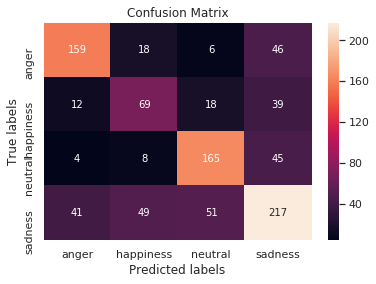


 Classification Report 
              precision    recall  f1-score   support

      anger       0.74      0.69      0.71       229
  happiness       0.48      0.50      0.49       138
    neutral       0.69      0.74      0.71       222
    sadness       0.63      0.61      0.62       358

avg / total       0.65      0.64      0.64       947
 

Train Epoch: 74 [0/3788 (0%)]	Loss: 1.081915

Train Epoch: 74 [1280/3788 (33%)]	Loss: 1.138777

Train Epoch: 74 [2560/3788 (67%)]	Loss: 1.165357


Train set: Average loss: 0.0087


Train Accuracy: 2372/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 598/947 (63%)



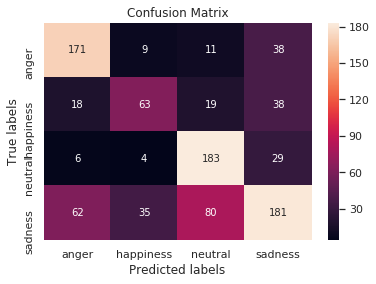


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.75      0.70       229
  happiness       0.57      0.46      0.51       138
    neutral       0.62      0.82      0.71       222
    sadness       0.63      0.51      0.56       358

avg / total       0.63      0.63      0.62       947
 

Train Epoch: 75 [0/3788 (0%)]	Loss: 1.100417

Train Epoch: 75 [1280/3788 (33%)]	Loss: 1.128054

Train Epoch: 75 [2560/3788 (67%)]	Loss: 1.019521


Train set: Average loss: 0.0087


Train Accuracy: 2371/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 590/947 (62%)



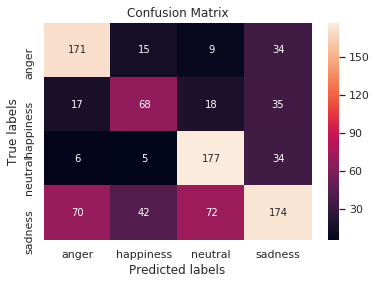


 Classification Report 
              precision    recall  f1-score   support

      anger       0.65      0.75      0.69       229
  happiness       0.52      0.49      0.51       138
    neutral       0.64      0.80      0.71       222
    sadness       0.63      0.49      0.55       358

avg / total       0.62      0.62      0.62       947
 

Train Epoch: 76 [0/3788 (0%)]	Loss: 1.079670

Train Epoch: 76 [1280/3788 (33%)]	Loss: 1.068430

Train Epoch: 76 [2560/3788 (67%)]	Loss: 1.117071


Train set: Average loss: 0.0087


Train Accuracy: 2390/3788 (63%)


Test set: Average loss: 0.0094, Accuracy: 613/947 (64%)



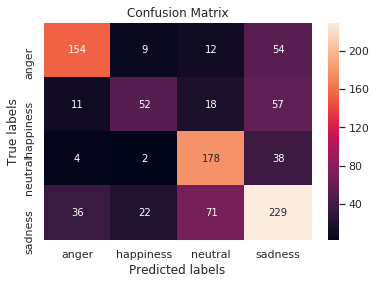


 Classification Report 
              precision    recall  f1-score   support

      anger       0.75      0.67      0.71       229
  happiness       0.61      0.38      0.47       138
    neutral       0.64      0.80      0.71       222
    sadness       0.61      0.64      0.62       358

avg / total       0.65      0.65      0.64       947
 

Train Epoch: 77 [0/3788 (0%)]	Loss: 1.095181

Train Epoch: 77 [1280/3788 (33%)]	Loss: 1.116255

Train Epoch: 77 [2560/3788 (67%)]	Loss: 1.040974


Train set: Average loss: 0.0088


Train Accuracy: 2329/3788 (61%)


Test set: Average loss: 0.0094, Accuracy: 593/947 (62%)



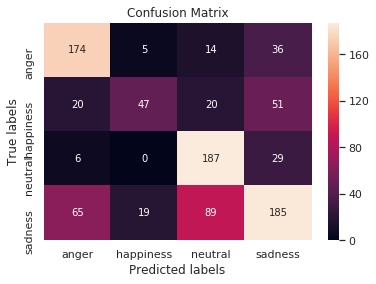


 Classification Report 
              precision    recall  f1-score   support

      anger       0.66      0.76      0.70       229
  happiness       0.66      0.34      0.45       138
    neutral       0.60      0.84      0.70       222
    sadness       0.61      0.52      0.56       358

avg / total       0.63      0.63      0.61       947
 

Train Epoch: 78 [0/3788 (0%)]	Loss: 1.084628

Train Epoch: 78 [1280/3788 (33%)]	Loss: 1.130826

Train Epoch: 78 [2560/3788 (67%)]	Loss: 1.050025


Train set: Average loss: 0.0087


Train Accuracy: 2378/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 597/947 (63%)



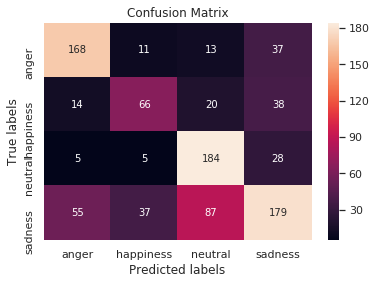


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.73      0.71       229
  happiness       0.55      0.48      0.51       138
    neutral       0.61      0.83      0.70       222
    sadness       0.63      0.50      0.56       358

avg / total       0.63      0.63      0.62       947
 

Train Epoch: 79 [0/3788 (0%)]	Loss: 1.113316

Train Epoch: 79 [1280/3788 (33%)]	Loss: 1.098550

Train Epoch: 79 [2560/3788 (67%)]	Loss: 1.073601


Train set: Average loss: 0.0087


Train Accuracy: 2388/3788 (63%)


Test set: Average loss: 0.0093, Accuracy: 601/947 (63%)



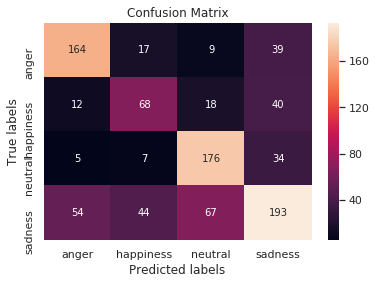


 Classification Report 
              precision    recall  f1-score   support

      anger       0.70      0.72      0.71       229
  happiness       0.50      0.49      0.50       138
    neutral       0.65      0.79      0.72       222
    sadness       0.63      0.54      0.58       358

avg / total       0.63      0.63      0.63       947
 

Train Epoch: 80 [0/3788 (0%)]	Loss: 1.086451

Train Epoch: 80 [1280/3788 (33%)]	Loss: 1.067515

Train Epoch: 80 [2560/3788 (67%)]	Loss: 1.070371


Train set: Average loss: 0.0087


Train Accuracy: 2360/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 591/947 (62%)



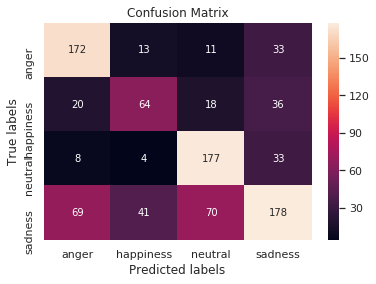


 Classification Report 
              precision    recall  f1-score   support

      anger       0.64      0.75      0.69       229
  happiness       0.52      0.46      0.49       138
    neutral       0.64      0.80      0.71       222
    sadness       0.64      0.50      0.56       358

avg / total       0.62      0.62      0.62       947
 

Train Epoch: 81 [0/3788 (0%)]	Loss: 1.038566

Train Epoch: 81 [1280/3788 (33%)]	Loss: 1.027894

Train Epoch: 81 [2560/3788 (67%)]	Loss: 1.092160


Train set: Average loss: 0.0087


Train Accuracy: 2397/3788 (63%)


Test set: Average loss: 0.0094, Accuracy: 569/947 (60%)



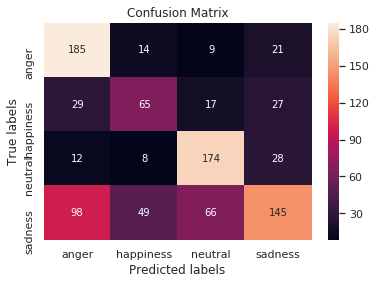


 Classification Report 
              precision    recall  f1-score   support

      anger       0.57      0.81      0.67       229
  happiness       0.48      0.47      0.47       138
    neutral       0.65      0.78      0.71       222
    sadness       0.66      0.41      0.50       358

avg / total       0.61      0.60      0.59       947
 

Train Epoch: 82 [0/3788 (0%)]	Loss: 1.119366

Train Epoch: 82 [1280/3788 (33%)]	Loss: 1.149494

Train Epoch: 82 [2560/3788 (67%)]	Loss: 1.118391


Train set: Average loss: 0.0087


Train Accuracy: 2374/3788 (62%)


Test set: Average loss: 0.0094, Accuracy: 612/947 (64%)



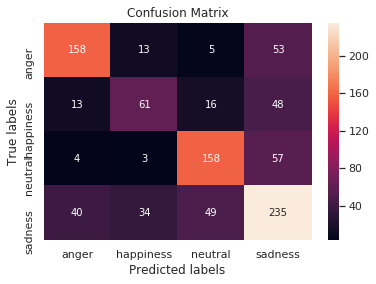


 Classification Report 
              precision    recall  f1-score   support

      anger       0.73      0.69      0.71       229
  happiness       0.55      0.44      0.49       138
    neutral       0.69      0.71      0.70       222
    sadness       0.60      0.66      0.63       358

avg / total       0.65      0.65      0.64       947
 

Train Epoch: 83 [0/3788 (0%)]	Loss: 1.187330

Train Epoch: 83 [1280/3788 (33%)]	Loss: 1.072412

Train Epoch: 83 [2560/3788 (67%)]	Loss: 1.043364


Train set: Average loss: 0.0087


Train Accuracy: 2367/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 594/947 (62%)



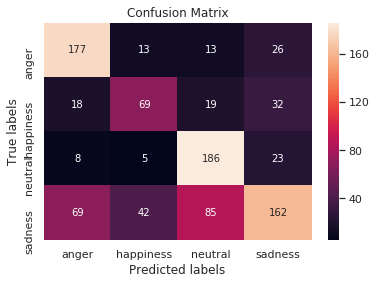


 Classification Report 
              precision    recall  f1-score   support

      anger       0.65      0.77      0.71       229
  happiness       0.53      0.50      0.52       138
    neutral       0.61      0.84      0.71       222
    sadness       0.67      0.45      0.54       358

avg / total       0.63      0.63      0.62       947
 

Train Epoch: 84 [0/3788 (0%)]	Loss: 1.070378

Train Epoch: 84 [1280/3788 (33%)]	Loss: 1.080096

Train Epoch: 84 [2560/3788 (67%)]	Loss: 1.138666


Train set: Average loss: 0.0087


Train Accuracy: 2401/3788 (63%)


Test set: Average loss: 0.0094, Accuracy: 564/947 (59%)



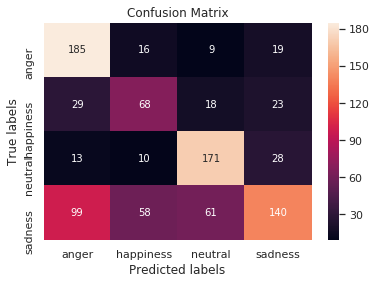


 Classification Report 
              precision    recall  f1-score   support

      anger       0.57      0.81      0.67       229
  happiness       0.45      0.49      0.47       138
    neutral       0.66      0.77      0.71       222
    sadness       0.67      0.39      0.49       358

avg / total       0.61      0.60      0.58       947
 

Train Epoch: 85 [0/3788 (0%)]	Loss: 1.066516

Train Epoch: 85 [1280/3788 (33%)]	Loss: 1.091945

Train Epoch: 85 [2560/3788 (67%)]	Loss: 1.158822


Train set: Average loss: 0.0087


Train Accuracy: 2349/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 601/947 (63%)



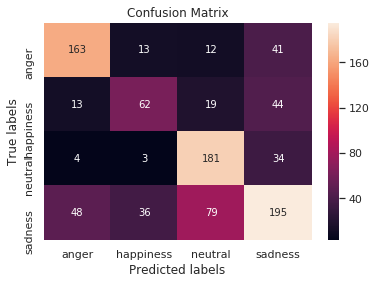


 Classification Report 
              precision    recall  f1-score   support

      anger       0.71      0.71      0.71       229
  happiness       0.54      0.45      0.49       138
    neutral       0.62      0.82      0.71       222
    sadness       0.62      0.54      0.58       358

avg / total       0.63      0.63      0.63       947
 

Train Epoch: 86 [0/3788 (0%)]	Loss: 1.025164

Train Epoch: 86 [1280/3788 (33%)]	Loss: 1.051856

Train Epoch: 86 [2560/3788 (67%)]	Loss: 1.103199


Train set: Average loss: 0.0087


Train Accuracy: 2378/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 586/947 (61%)



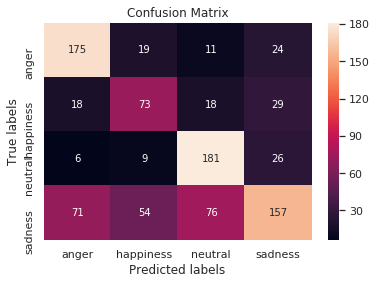


 Classification Report 
              precision    recall  f1-score   support

      anger       0.65      0.76      0.70       229
  happiness       0.47      0.53      0.50       138
    neutral       0.63      0.82      0.71       222
    sadness       0.67      0.44      0.53       358

avg / total       0.63      0.62      0.61       947
 

Train Epoch: 87 [0/3788 (0%)]	Loss: 1.097722

Train Epoch: 87 [1280/3788 (33%)]	Loss: 1.115341

Train Epoch: 87 [2560/3788 (67%)]	Loss: 1.080789


Train set: Average loss: 0.0087


Train Accuracy: 2380/3788 (62%)


Test set: Average loss: 0.0094, Accuracy: 574/947 (60%)



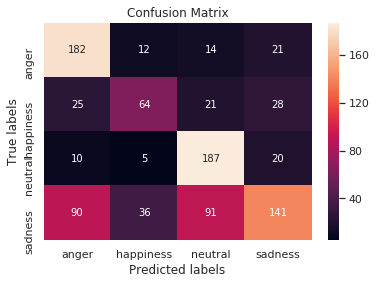


 Classification Report 
              precision    recall  f1-score   support

      anger       0.59      0.79      0.68       229
  happiness       0.55      0.46      0.50       138
    neutral       0.60      0.84      0.70       222
    sadness       0.67      0.39      0.50       358

avg / total       0.62      0.61      0.59       947
 

Train Epoch: 88 [0/3788 (0%)]	Loss: 1.066788

Train Epoch: 88 [1280/3788 (33%)]	Loss: 1.141794

Train Epoch: 88 [2560/3788 (67%)]	Loss: 0.981621


Train set: Average loss: 0.0087


Train Accuracy: 2371/3788 (62%)


Test set: Average loss: 0.0092, Accuracy: 581/947 (61%)



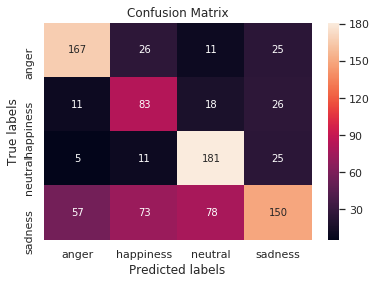


 Classification Report 
              precision    recall  f1-score   support

      anger       0.70      0.73      0.71       229
  happiness       0.43      0.60      0.50       138
    neutral       0.63      0.82      0.71       222
    sadness       0.66      0.42      0.51       358

avg / total       0.63      0.61      0.61       947
 

Train Epoch: 89 [0/3788 (0%)]	Loss: 1.085302

Train Epoch: 89 [1280/3788 (33%)]	Loss: 1.056798

Train Epoch: 89 [2560/3788 (67%)]	Loss: 1.074638


Train set: Average loss: 0.0086


Train Accuracy: 2381/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 606/947 (63%)



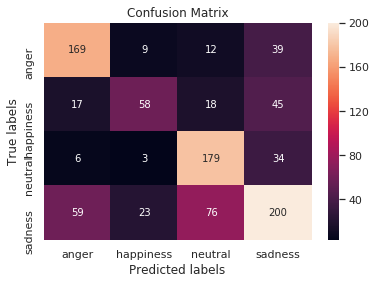


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.74      0.70       229
  happiness       0.62      0.42      0.50       138
    neutral       0.63      0.81      0.71       222
    sadness       0.63      0.56      0.59       358

avg / total       0.64      0.64      0.63       947
 

Train Epoch: 90 [0/3788 (0%)]	Loss: 1.095497

Train Epoch: 90 [1280/3788 (33%)]	Loss: 1.051513

Train Epoch: 90 [2560/3788 (67%)]	Loss: 1.133459


Train set: Average loss: 0.0086


Train Accuracy: 2422/3788 (63%)


Test set: Average loss: 0.0093, Accuracy: 597/947 (63%)



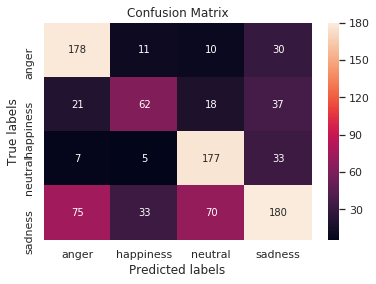


 Classification Report 
              precision    recall  f1-score   support

      anger       0.63      0.78      0.70       229
  happiness       0.56      0.45      0.50       138
    neutral       0.64      0.80      0.71       222
    sadness       0.64      0.50      0.56       358

avg / total       0.63      0.63      0.62       947
 

Train Epoch: 91 [0/3788 (0%)]	Loss: 1.090800

Train Epoch: 91 [1280/3788 (33%)]	Loss: 1.064431

Train Epoch: 91 [2560/3788 (67%)]	Loss: 1.151755


Train set: Average loss: 0.0087


Train Accuracy: 2351/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 595/947 (62%)



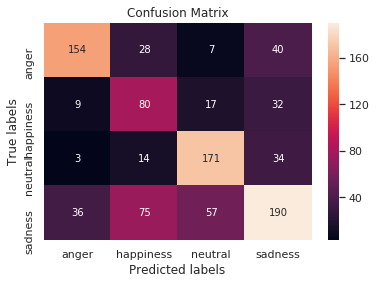


 Classification Report 
              precision    recall  f1-score   support

      anger       0.76      0.67      0.71       229
  happiness       0.41      0.58      0.48       138
    neutral       0.68      0.77      0.72       222
    sadness       0.64      0.53      0.58       358

avg / total       0.65      0.63      0.63       947
 

Train Epoch: 92 [0/3788 (0%)]	Loss: 1.140153

Train Epoch: 92 [1280/3788 (33%)]	Loss: 1.102398

Train Epoch: 92 [2560/3788 (67%)]	Loss: 1.016415


Train set: Average loss: 0.0086


Train Accuracy: 2402/3788 (63%)


Test set: Average loss: 0.0092, Accuracy: 588/947 (62%)



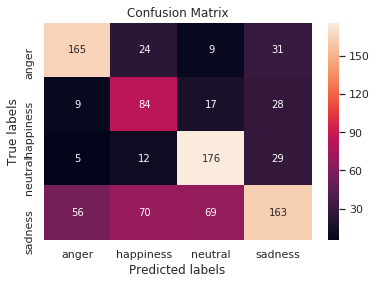


 Classification Report 
              precision    recall  f1-score   support

      anger       0.70      0.72      0.71       229
  happiness       0.44      0.61      0.51       138
    neutral       0.65      0.79      0.71       222
    sadness       0.65      0.46      0.54       358

avg / total       0.63      0.62      0.62       947
 

Train Epoch: 93 [0/3788 (0%)]	Loss: 1.170429

Train Epoch: 93 [1280/3788 (33%)]	Loss: 1.033832

Train Epoch: 93 [2560/3788 (67%)]	Loss: 1.052200


Train set: Average loss: 0.0086


Train Accuracy: 2431/3788 (64%)


Test set: Average loss: 0.0092, Accuracy: 585/947 (61%)



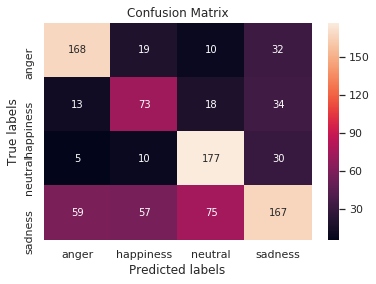


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.73      0.71       229
  happiness       0.46      0.53      0.49       138
    neutral       0.63      0.80      0.71       222
    sadness       0.63      0.47      0.54       358

avg / total       0.62      0.62      0.61       947
 

Train Epoch: 94 [0/3788 (0%)]	Loss: 1.149420

Train Epoch: 94 [1280/3788 (33%)]	Loss: 1.048834

Train Epoch: 94 [2560/3788 (67%)]	Loss: 1.041553


Train set: Average loss: 0.0086


Train Accuracy: 2407/3788 (63%)


Test set: Average loss: 0.0093, Accuracy: 582/947 (61%)



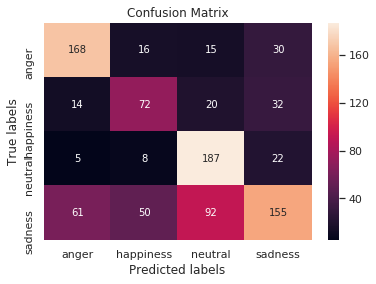


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.73      0.70       229
  happiness       0.49      0.52      0.51       138
    neutral       0.60      0.84      0.70       222
    sadness       0.65      0.43      0.52       358

avg / total       0.62      0.61      0.60       947
 

Train Epoch: 95 [0/3788 (0%)]	Loss: 1.051201

Train Epoch: 95 [1280/3788 (33%)]	Loss: 1.070971

Train Epoch: 95 [2560/3788 (67%)]	Loss: 1.039109


Train set: Average loss: 0.0086


Train Accuracy: 2394/3788 (63%)


Test set: Average loss: 0.0094, Accuracy: 575/947 (60%)



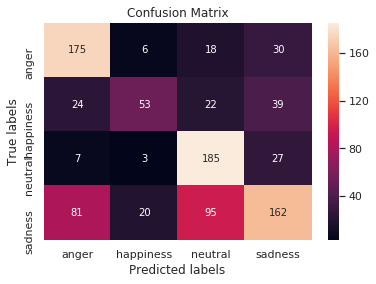


 Classification Report 
              precision    recall  f1-score   support

      anger       0.61      0.76      0.68       229
  happiness       0.65      0.38      0.48       138
    neutral       0.58      0.83      0.68       222
    sadness       0.63      0.45      0.53       358

avg / total       0.61      0.61      0.59       947
 

Train Epoch: 96 [0/3788 (0%)]	Loss: 1.083234

Train Epoch: 96 [1280/3788 (33%)]	Loss: 1.111140

Train Epoch: 96 [2560/3788 (67%)]	Loss: 1.121801


Train set: Average loss: 0.0087


Train Accuracy: 2377/3788 (62%)


Test set: Average loss: 0.0093, Accuracy: 613/947 (64%)



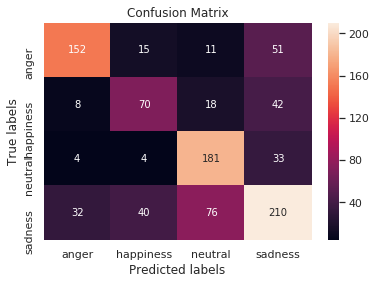


 Classification Report 
              precision    recall  f1-score   support

      anger       0.78      0.66      0.72       229
  happiness       0.54      0.51      0.52       138
    neutral       0.63      0.82      0.71       222
    sadness       0.62      0.59      0.61       358

avg / total       0.65      0.65      0.65       947
 

Train Epoch: 97 [0/3788 (0%)]	Loss: 1.074781

Train Epoch: 97 [1280/3788 (33%)]	Loss: 1.107472

Train Epoch: 97 [2560/3788 (67%)]	Loss: 1.115944


Train set: Average loss: 0.0087


Train Accuracy: 2380/3788 (62%)


Test set: Average loss: 0.0092, Accuracy: 585/947 (61%)



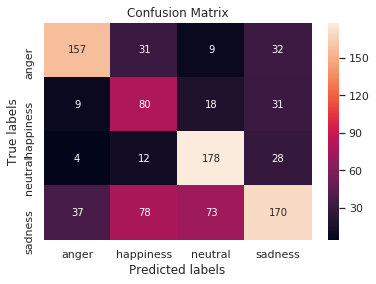


 Classification Report 
              precision    recall  f1-score   support

      anger       0.76      0.69      0.72       229
  happiness       0.40      0.58      0.47       138
    neutral       0.64      0.80      0.71       222
    sadness       0.65      0.47      0.55       358

avg / total       0.64      0.62      0.62       947
 

Train Epoch: 98 [0/3788 (0%)]	Loss: 1.042355

Train Epoch: 98 [1280/3788 (33%)]	Loss: 1.056996

Train Epoch: 98 [2560/3788 (67%)]	Loss: 1.052446


Train set: Average loss: 0.0086


Train Accuracy: 2415/3788 (63%)


Test set: Average loss: 0.0092, Accuracy: 593/947 (62%)



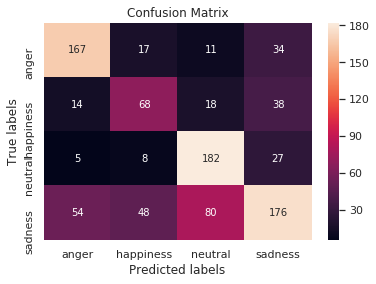


 Classification Report 
              precision    recall  f1-score   support

      anger       0.70      0.73      0.71       229
  happiness       0.48      0.49      0.49       138
    neutral       0.63      0.82      0.71       222
    sadness       0.64      0.49      0.56       358

avg / total       0.63      0.63      0.62       947
 

Train Epoch: 99 [0/3788 (0%)]	Loss: 1.133898

Train Epoch: 99 [1280/3788 (33%)]	Loss: 1.166277

Train Epoch: 99 [2560/3788 (67%)]	Loss: 1.122696


Train set: Average loss: 0.0086


Train Accuracy: 2408/3788 (63%)


Test set: Average loss: 0.0093, Accuracy: 574/947 (60%)



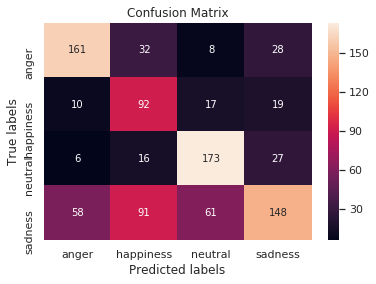


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.70      0.69       229
  happiness       0.40      0.67      0.50       138
    neutral       0.67      0.78      0.72       222
    sadness       0.67      0.41      0.51       358

avg / total       0.63      0.61      0.60       947
 

Train Epoch: 100 [0/3788 (0%)]	Loss: 1.054249

Train Epoch: 100 [1280/3788 (33%)]	Loss: 1.067752

Train Epoch: 100 [2560/3788 (67%)]	Loss: 1.071951


Train set: Average loss: 0.0087


Train Accuracy: 2383/3788 (62%)


Test set: Average loss: 0.0092, Accuracy: 604/947 (63%)



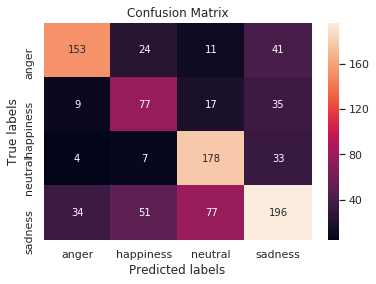


 Classification Report 
              precision    recall  f1-score   support

      anger       0.77      0.67      0.71       229
  happiness       0.48      0.56      0.52       138
    neutral       0.63      0.80      0.70       222
    sadness       0.64      0.55      0.59       358

avg / total       0.65      0.64      0.64       947
 



In [95]:
history = []
n_epoch = 101
for epoch in range(1, n_epoch):
#     exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch, model)
    
    test_loss, test_acc = test(model)
    
#     plateau_scheduler.step(test_loss)
    
    history.append([train_loss, train_acc, test_loss, test_acc])

In [96]:
history_df = pd.DataFrame(history, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [97]:
history_df["epoch"] = [x for x in range(1, n_epoch)]

In [98]:
history_df

,train_loss,train_acc,test_loss,test_acc,epoch
0,0.010341,41,0.010599,42,1
1,0.009838,48,0.010334,53,2
2,0.009645,51,0.010136,51,3
3,0.009526,52,0.009942,57,4
4,0.009382,54,0.009829,54,5
5,0.009299,54,0.009840,54,6
6,0.009231,56,0.009685,59,7
7,0.009235,57,0.009638,57,8
8,0.009177,57,0.009643,55,9
9,0.009108,57,0.009608,60,10


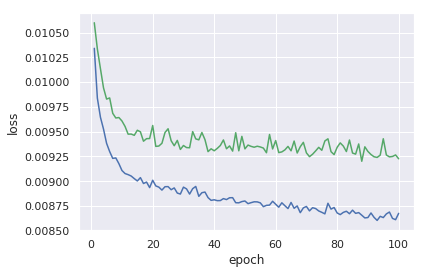

In [99]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_loss', data=history_df, color='g')
plt.ylabel("loss")
plt.show()

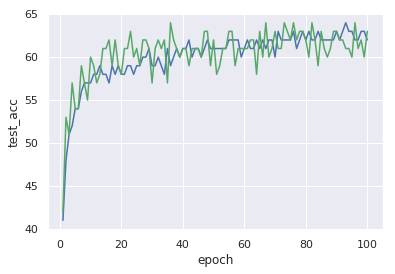

In [100]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_acc', data=history_df, color='g')
plt.show()